In [42]:
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1DTranspose, Conv1D, Flatten, Add, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model

In [66]:
def create_convnet(N, n0, img_path='convnet_image.png'):
    """_summary_

    Args:
        N (_type_): _description_
        n0 (_type_): _description_
        img_path (str, optional): _description_. Defaults to 'convnet_image.png'.

    Returns:
        _type_: _description_
    """
    
    model = Sequential()   
    input_shape = tf.keras.Input(shape=(N, 1))
    
    normalize = BatchNormalization()(input_shape)
    relu_layer = Activation('relu')(normalize)

    # skip connection
    skipConnection0 = Conv1D(filters=n0, kernel_size=1)(relu_layer)
    
    ## D Block 01
    Dtower_7 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(relu_layer)
    # parallel layer
    Dtower_parallel_01 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(relu_layer)
    Dtower_8 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(Dtower_7)
    D01_added = Add()([Dtower_8, Dtower_parallel_01])
     
    # skip connection
    skipConnection1 = Conv1D(filters=n0, kernel_size=1)(D01_added)
    
    ## D Block 02
    Dtower_5 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D01_added)
    # parallel layer
    Dtower_parallel_02 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D01_added)  
    Dtower_6 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(Dtower_5)
    D02_added = Add()([Dtower_6, Dtower_parallel_02])
    
    # skip connection
    skipConnection2 = Conv1D(filters=n0, kernel_size=1)(D02_added)
    
    ## D Block 03
    Dtower_3 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D02_added)
    # parallel layer
    Dtower_parallel_03 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D02_added)  
    Dtower_4 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(Dtower_3)
    D03_added = Add()([Dtower_4, Dtower_parallel_03])

    ## U Block 03 
    tower_1 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D03_added)
    # parallel layer
    tower_parallel_03 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D03_added)
    tower_2 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(tower_1)
    U01_added = Add()([tower_2, tower_parallel_03, skipConnection2])

    ## U Block 02
    tower_3 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(U01_added)
    # parallel layer
    tower_parallel_02 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(U01_added) 
    tower_4 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(tower_3)
    U02_added = Add()([tower_4, tower_parallel_02, skipConnection1])
    
    ## U Block 01
    tower_5 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(U02_added)
    # parallel layer
    tower_parallel_01 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(U02_added)  
    tower_6 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(tower_5)
    U03_added = Add()([tower_6, tower_parallel_01, skipConnection0])
    
    # output layer
    output_layer = Conv1D(2, kernel_size=3, activation='linear')(U03_added)
    # output layer
    #flatten = Flatten()(output_layer)
    #output = Dense(2, activation='linear')(flatten)

    model = tf.keras.Model(input_shape, output_layer)
    plot_model(model, to_file=img_path, show_layer_names=True, show_layer_activations=True)
    
    return model

In [67]:
model = create_convnet(256, 32)
model.summary()

(None, 256, 1)
(None, 256, 32)
(None, 128, 32)
(None, 128, 32)
(None, 128, 32)
(None, 128, 32)
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 256, 1)]     0           []                               
                                                                                                  
 batch_normalization_31 (BatchN  (None, 256, 1)      4           ['input_32[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_11 (Activation)     (None, 256, 1)       0           ['batch_normalization_31[0][0]'] 
                                                                                                

In [48]:
import visualkeras
from PIL import ImageFont

model = create_convnet(128, 32)
path_image = 'C:/Users/Silas/Documents/PIVIC-Comunicacoes-Opticas/resultados/Figuras' 

font = ImageFont.truetype('arial.ttf', 20)

# Plot CNN
visualkeras.layered_view(model, to_file=path_image+'/NN_plot.png', spacing=24, legend=True, font=font).show()

### Simulation of a single polarization optical signal transmission

In [43]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from optic.models import phaseNoise, linFiberCh, KramersKronigRx, photodiode

from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from optic.plot import pconst

import scipy.constants as const
from tqdm.notebook import tqdm

In [44]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 0       # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16           # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
FO = paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

# photodiode parameters
paramPD = parameters()
paramPD.B  = 1.1*paramTx.Rs
paramPD.Fs = Fs

### Core simulation code

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB


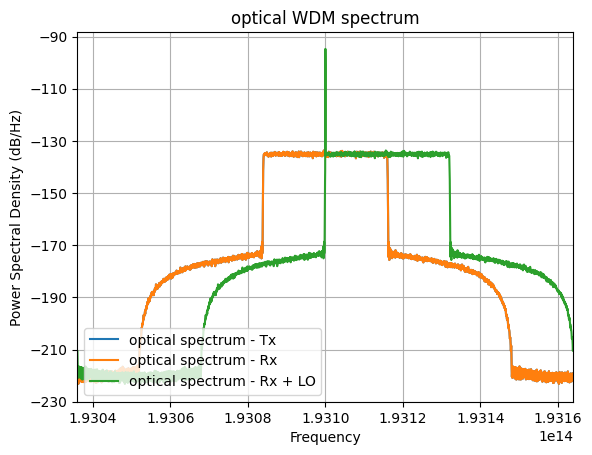

In [45]:
# generate optical signal signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simulate linear signal propagation
sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

# plots optical spectrum before and after transmission

# before
plt.figure()
plt.xlim(paramTx.Fc - Fs / 2, paramTx.Fc + Fs / 2)
plt.psd(
    sigTx[:, 0],
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Tx",
)

# after
plt.psd(
    sigCh,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx",
)
plt.legend(loc="lower left")
plt.title("optical spectrum")

# receiver detection and demodulation

Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]

Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# generate LO field
π = np.pi
t = np.arange(0, len(sigCh))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Add LO to the received signal
sigRx = np.sqrt(Plo) + sigCh* np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm   = sigRx.copy()

print('CSPR = %.2f dB'%(10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

# plot spectrum fter adding LO
plt.psd(
    sigRx,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx + LO",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

### Phase-retrieval stage

SIR =  25.44  dB


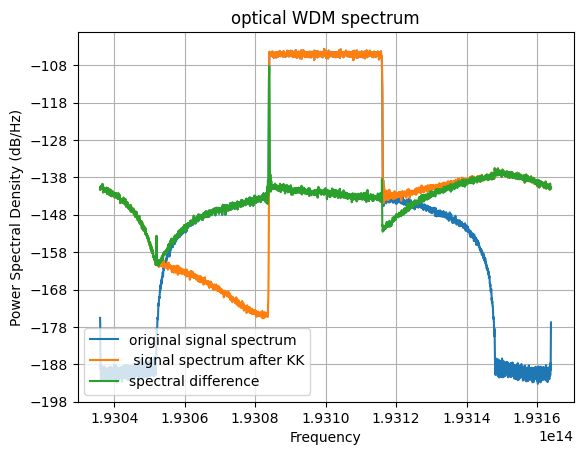

In [46]:
# simulate ideal direct-detection optical receiver
Ipd = photodiode(sigRx, paramPD)
Amp = np.sqrt(Ipd)
Amp = resample(Amp, paramADC)

# resampling to ADC sampling rate
sigCh = resample(sigCh, paramADC)
sfm = resample(sfm, paramADC)
newFs = paramADC.SpS_out*paramTx.Rs

# Kramers-Kronig phase-retrieval
phiTime = KramersKronigRx(Amp, newFs)

# optical field reconstruction
sigRx = Amp*np.exp(1j*phiTime)
sfm_KK = sigRx.copy()

# remove DC level
sigRx -= np.sqrt(Plo)  # np.mean(sigRx)

# downshift to baseband
t = np.arange(0, len(sigRx))*(1/newFs)
sigRx *= np.exp(-1j * (2 * π * FO * t))

# plot spectrum of  the reconstructed field

# plot spectrum of  the reconstructed field
plt.psd(
    sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="original signal spectrum",
)

plt.psd(
    sigRx/np.sqrt(signal_power(sigRx)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label=" signal spectrum after KK",
)

# correct for (possible) phase ambiguity
rot = np.mean(sigCh/sigRx)
sigRx = rot * sigRx
sigRx = sigRx / np.sqrt(signal_power(sigRx))

# plot spectrum of  the reconstructed field
plt.psd(
    sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="spectral difference",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

# calculate interference
intf = sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh))

SIR = 1/signal_power(intf)

print('SIR = ', round(10*np.log10(SIR),2), ' dB')

#### Standard receiver processing

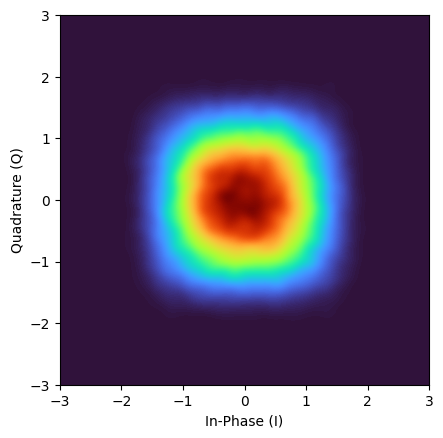

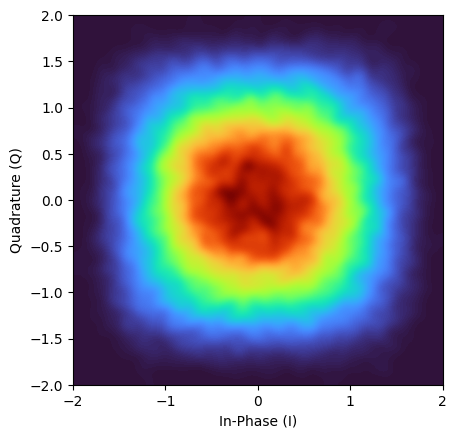

In [47]:
# resample to 2 samples/symbol:
paramRes = parameters()
paramRes.Rs = paramTx.Rs
paramRes.SpS_in = paramADC.SpS_out
paramRes.SpS_out = 2

sigRx = resample(sigRx, paramRes)

# Matched filtering and CD compensation

# Matched filtering
if paramTx.pulse == "nrz":
    pulse = pulseShape("nrz", paramADC.SpS_out)
elif paramTx.pulse == "rrc":
    pulse = pulseShape(
        "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
    )

pulse = pulse / np.max(np.abs(pulse))
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

# CD compensation
sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

#plot constellations after CD compensation
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

# Downsampling to 2 sps and re-synchronization with transmitted sequences
sigRx = sigRx.reshape(-1, 1)

symbRx = symbolSync(sigRx, symbTx, 2)

  0%|          | 0/5 [00:00<?, ?it/s]

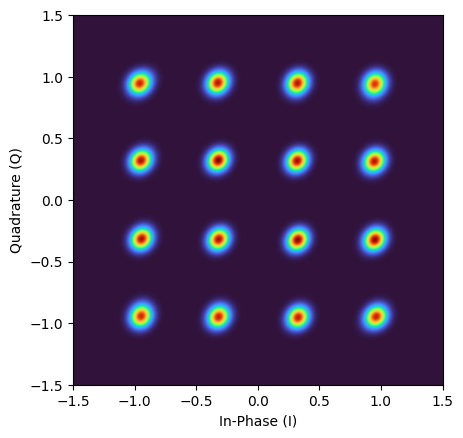

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [48]:
# Power normalization
x = sigRx
d = symbRx

x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

# Adaptive equalization
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = 2
paramEq.mu = [5e-3, 2e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg = ["nlms", "dd-lms"]
paramEq.M = paramTx.M
paramEq.L = [20000, 80000]

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

discard = int(paramEq.L[0]/2)

#plot constellations after adaptive equalization
pconst(y_EQ[discard:-discard, :], lim=True)

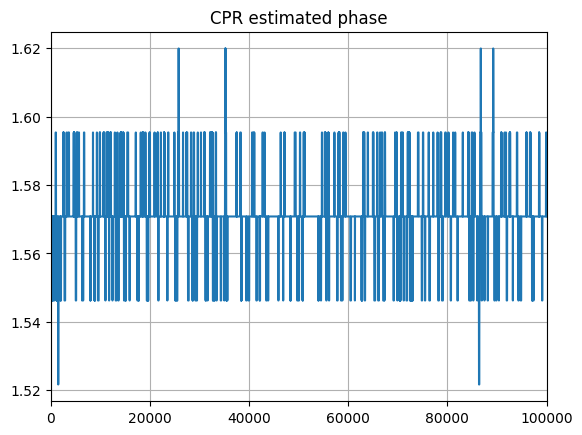

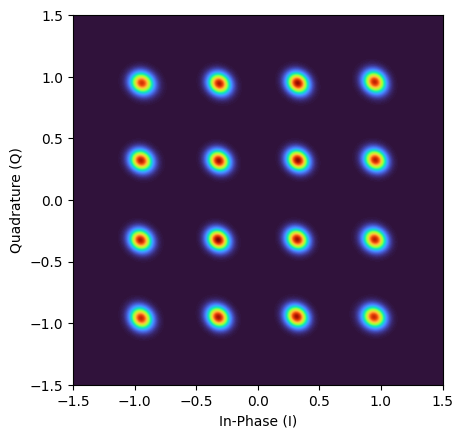

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [49]:
# Carrier phase recovery
paramCPR = parameters()
paramCPR.alg = "bps"
paramCPR.M = paramTx.M
paramCPR.N = 75
paramCPR.B = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

plt.figure()
plt.title("CPR estimated phase")
plt.plot(θ, "-")
plt.xlim(0, len(θ))
plt.grid()

discard = 5000

# plot constellations after CPR
pconst(y_CPR[discard:-discard, :], lim=True)

#### Evaluate transmission metrics

In [50]:
# correct for (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:, k] / y_CPR[:, k])
    y_CPR[:, k] = rot * y_CPR[:, k]

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

ind = np.arange(discard, d.shape[0] - discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
GMI, _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
MI = monteCarloMI(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')

print("Results:\n")
print("SER: %.2e" % (SER[0]))
print("BER: %.2e" % (BER[0]))
print("SNR: %.2f dB" % (SNR[0]))
print("MI: %.2f bits" % (MI[0]))
print("GMI: %.2f bits" % (GMI[0]));

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 27.94 dB
MI: 4.00 bits
GMI: 4.00 bits


### Neural network training 

In [ ]:
N = 128 # number of input amplitude samples to the NN

sfm = sfm/np.sqrt(signal_power(sfm))

sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
sigAmp   = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

# create set of input features
X_train = np.zeros((len(sigPhase), N)) #(L,N)

for indPhase in range(len(sigPhase)):
    X_train[indPhase] = sigAmp[indPhase:N+indPhase]

# create set of phase labels
y_train = np.array([sfm.real, sfm.imag]).T

# define neural network model
stop = EarlyStopping(monitor='val_loss', patience=5)
model = create_convnet(N)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, epochs=100, callbacks=[stop], validation_split=0.3, batch_size=256)
model.summary()

model.save('ConvNets_models/convnet_model_SpS_'+str(paramTx.SpS), save_format='h5')

In [12]:
#model = tf.keras.models.load_model(r'C:\Users\optic\Documents\PIVIC-PIBIC-Comunicacoes-Opticas\jupyter notebooks\ConvNets_models\convnet_model_SpS_4')
sfm_NN = model.predict(X_train)

12500/12500 [==============================] - 53s 4ms/step


C:\Users\optic\AppData\Local\Temp\ipykernel_5932\2632733575.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-x" (-> color='k'). The keyword argument will take precedence.
  plt.plot(np.real(sfm)[300:400],'k-x',color='black', label='True - Real')


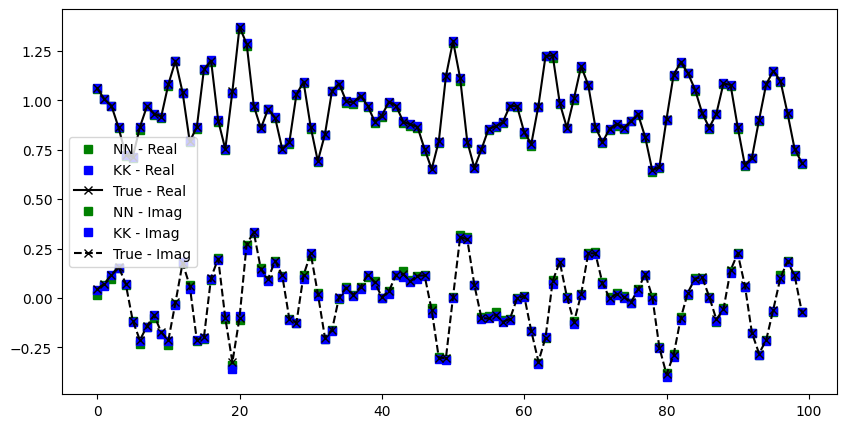

In [47]:
sfm_KK = sfm_KK/np.sqrt(signal_power(sfm_KK))

plt.figure(figsize=(10,5))
plt.plot(sfm_NN[300:400,0],'s',color='g',label='NN - Real')
plt.plot(np.real(sfm_KK)[300:400],'s',color='b',label='KK - Real')
plt.plot(np.real(sfm)[300:400],'k-x',color='black', label='True - Real')

plt.plot(sfm_NN[300:400,1],'s',color='g',label='NN - Imag')
plt.plot(np.imag(sfm_KK)[300:400],'s',color='b',label='KK - Imag')
plt.plot(np.imag(sfm)[300:400],'k--x',label='True - Imag')

plt.legend();

In [ ]:
N = np.array([32, 64, 128, 256, 512]) # number of input amplitude samples to the NN
MSE = np.zeros(N.size)

for indNN, indNN_ in enumerate(tqdm(N)):
    
    N = indNN_
    sfm = sfm/np.sqrt(signal_power(sfm))

    sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
    sigAmp   = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

    # create set of input features
    X_train = np.zeros((len(sigPhase), N)) #(L,N)

    for indPhase in range(len(sigPhase)):
        X_train[indPhase] = sigAmp[indPhase:N+indPhase]

    # create set of phase labels
    y_train = np.array([sfm.real, sfm.imag]).T

    # define neural network model
    stop = EarlyStopping(monitor='val_loss', patience=5)
    model = create_convnet(N)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    history = model.fit(X_train, y_train, epochs=100, callbacks=[stop], validation_split=0.3, batch_size=256)
    model.summary()

    #model.save('ConvNets_models/convnet_model_SpS_'+str(paramTx.SpS), save_format='h5')
    mse_train  = np.mean(history.history['loss'])
    MSE[indNN] = mse_train

C:\Users\optic\AppData\Local\Temp\ipykernel_5932\741632973.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--o" (-> color='k'). The keyword argument will take precedence.
  plt.plot(N, 20*np.log10(MSE), 'k--o', color='b', label='ConvNet training samples')


Text(0.5, 1.0, 'Sample Saturation Analysis')

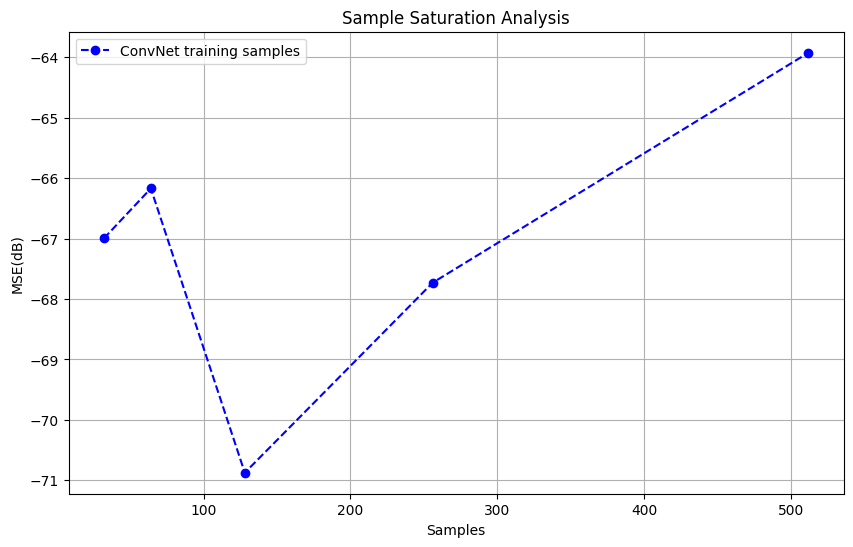

In [54]:
plt.figure(num=None, figsize=(10, 6))
plt.plot(N, 20*np.log10(MSE), 'k--o', color='b', label='ConvNet training samples')
plt.grid()
plt.legend()
plt.xlabel('Samples')
plt.ylabel('MSE(dB)')
plt.title('Sample Saturation Analysis')

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 50s 4ms/step
SIR =  22.87  dB


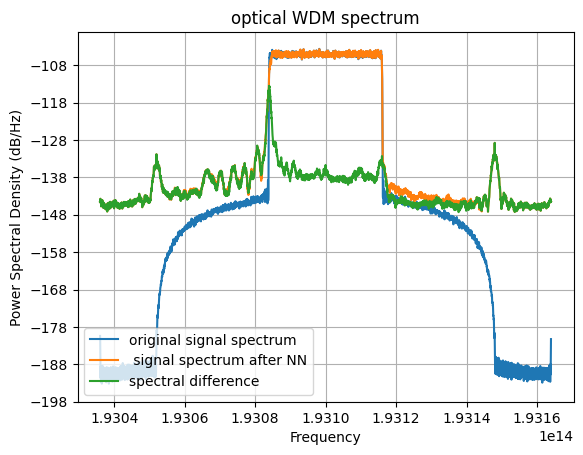

In [19]:
# generate optical signal signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simulate linear signal propagation
sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

# receiver detection and demodulation
Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]

Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# generate LO field
π = np.pi
t = np.arange(0, len(sigCh))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Add LO to the received signal
sigRx = np.sqrt(Plo) + sigCh* np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm   = sigRx.copy()

print('CSPR = %.2f dB'%(10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

# simulate ideal direct-detection optical receiver
Ipd = photodiode(sigRx, paramPD)
Amp = np.sqrt(Ipd)
Amp = resample(Amp, paramADC)

# resampling to ADC sampling rate
sigCh = resample(sigCh, paramADC)
sfm = resample(sfm, paramADC)
newFs = paramADC.SpS_out*paramTx.Rs

sfm = sfm/np.sqrt(signal_power(sfm))

sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
sigAmp   = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

# create set of input features
X_input = np.zeros((len(sigPhase), N)) #(L,N)

for indPhase in range(len(sigPhase)):
    X_input[indPhase] = sigAmp[indPhase:N+indPhase]

sigRx_NN = model.predict(X_input)
# optical field reconstruction
sigRx = sigRx_NN[:,0]+1j*sigRx_NN[:,1]

# remove DC level
sigRx -= np.mean(sigRx) # np.sqrt(Plo)

# downshift to baseband
t = np.arange(0, len(sigRx))*(1/newFs)
sigRx *= np.exp(-1j * (2 * π * FO * t))

# plot spectrum of  the reconstructed field
plt.psd(
    sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="original signal spectrum",
)

plt.psd(
    sigRx/np.sqrt(signal_power(sigRx)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label=" signal spectrum after NN",
)

# correct for (possible) phase ambiguity
rot = np.mean(sigCh/sigRx)
sigRx = rot * sigRx
sigRx = sigRx / np.sqrt(signal_power(sigRx))

# plot spectrum of  the reconstructed field
plt.psd(
    sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="spectral difference",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

intf = sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh))

SIR = 1/signal_power(intf)

print('SIR = ', round(10*np.log10(SIR), 2), ' dB')

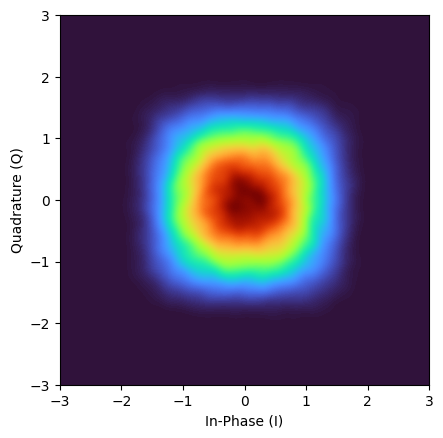

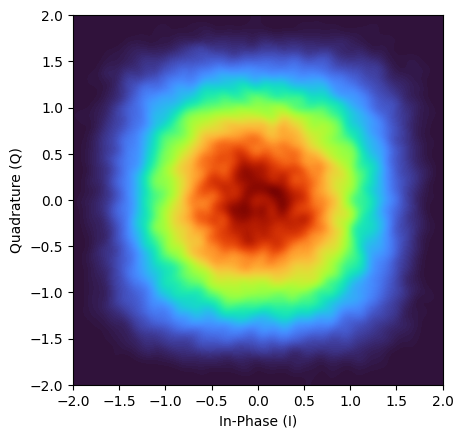

  0%|          | 0/5 [00:00<?, ?it/s]

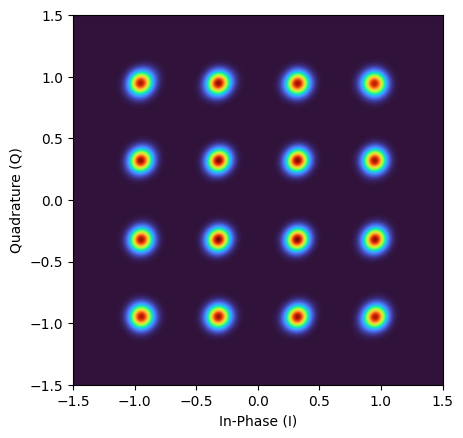

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [20]:
# resample to 2 samples/symbol:
paramRes = parameters()
paramRes.Rs = paramTx.Rs
paramRes.SpS_in  = paramADC.SpS_out
paramRes.SpS_out = 2

sigRx = resample(sigRx, paramRes)

# Matched filtering and CD compensation

# Matched filtering
if paramTx.pulse == "nrz":
    pulse = pulseShape("nrz", paramADC.SpS_out)
elif paramTx.pulse == "rrc":
    pulse = pulseShape(
        "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
    )

pulse = pulse / np.max(np.abs(pulse))
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

# CD compensation
sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

#plot constellations after CD compensation
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

# Downsampling to 2 sps and re-synchronization with transmitted sequences
sigRx = sigRx.reshape(-1, 1)

symbRx = symbolSync(sigRx, symbTx, 2)

# Power normalization
x = sigRx
d = symbRx

x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

# Adaptive equalization
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = 2
paramEq.mu = [5e-3, 2e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg = ["nlms", "dd-lms"]
paramEq.M = paramTx.M
paramEq.L = [20000, 80000]

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

discard = int(paramEq.L[0]/2)

#plot constellations after adaptive equalization
pconst(y_EQ[discard:-discard,:], lim=True)

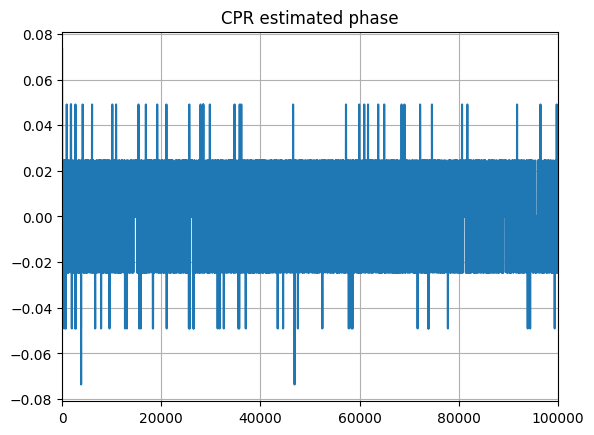

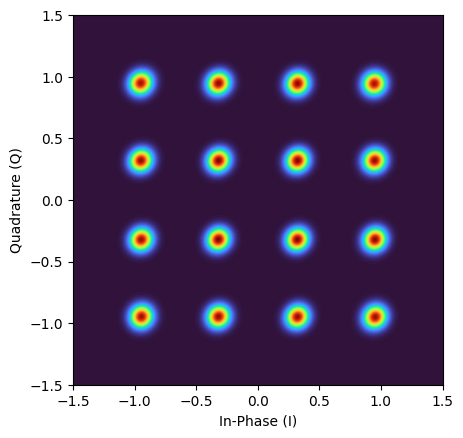

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [21]:
# Carrier phase recovery
paramCPR = parameters()
paramCPR.alg = "bps"
paramCPR.M = paramTx.M
paramCPR.N = 35
paramCPR.B = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

plt.figure()
plt.title("CPR estimated phase")
plt.plot(θ, "-")
plt.xlim(0, len(θ))
plt.grid()

discard = 5000

# plot constellations after CPR
pconst(y_CPR[discard:-discard, :], lim=True)

In [22]:
# correct for (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:, k] / y_CPR[:, k])
    y_CPR[:, k] = rot * y_CPR[:, k]

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

ind = np.arange(discard, d.shape[0] - discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
GMI, _ = monteCarloGMI(y_CPR[ind, :], d[ind, :],  paramTx.M, 'qam')
MI = monteCarloMI(y_CPR[ind, :], d[ind, :],  paramTx.M, 'qam')

print("Results:\n")
print("SER: %.2e" % (SER[0]))
print("BER: %.2e" % (BER[0]))
print("SNR: %.2f dB" % (SNR[0]))
print("MI: %.2f bits" % (MI[0]))
print("GMI: %.2f bits" % (GMI[0]))

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 26.28 dB
MI: 4.00 bits
GMI: 4.00 bits


In [6]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
#paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 100       # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16           # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]
Ts = 1 / Fs

## Receiver parameters:

# local oscillator (LO)
#FO = paramTx.Rs/2  # frequency offset
lw = 0*200e3        # linewidth
ϕ_lo = 0            # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

# photodiode parameters
paramPD = parameters()
paramPD.B  = 1.1*paramTx.Rs
paramPD.Fs = Fs

In [7]:
path = 'C:/Users/optic/Documents/PIVIC-PIBIC-Comunicacoes-Opticas/setups/Conv_models/'
N = 128 # number of input amplitude samples to the NN

Rolloff = np.arange(0.05, 0.95, 0.05)
FO_Values = np.arange(0e9, 6e9, 1e9)

for indexFO, indFO_ in enumerate(tqdm(FO_Values)):
    for indNN, indNN_ in enumerate(tqdm(Rolloff)):
        
        # Main simulation parameters
        paramTx.alphaRRC = indNN_
        FO = indFO_ + paramTx.Rs/2

        # generate optical signal signal
        sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)
        symbTx = symbTx_[:, :, chIndex]

        # simulate linear signal propagation
        sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)                  
          
        Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

        # generate LO field
        π = np.pi
        t = np.arange(0, len(sigCh))*Ts
        ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

        sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

        # Add LO to the received signal
        sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
        sfm = sigRx.copy()
                  
        # simulate ideal direct-detection optical receiver
        Ipd = photodiode(sigRx, paramPD)
        Amp = np.sqrt(Ipd)
        Amp = resample(Amp, paramADC)

        # resampling to ADC sampling rate
        sigCh = resample(sigCh, paramADC)
        sfm = resample(sfm, paramADC)
        newFs = paramADC.SpS_out*paramTx.Rs

        sfm = sfm/np.sqrt(signal_power(sfm))
          
        # Neural network training

        #sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
        sigAmp = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

        # create set of input features
        X_train = np.zeros((len(sfm), N)) #(L,N)

        for indPhase in range(len(sfm)):
            X_train[indPhase] = sigAmp[indPhase:N+indPhase]

        # create set of phase labels
        y_train = np.array([sfm.real, sfm.imag]).T

        # define neural network model
        stop = EarlyStopping(monitor='val_loss', patience=5)
        model = create_convnet(N)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
        model.fit(X_train, y_train, epochs=100, callbacks=[stop], validation_split=0.3, batch_size=256)
        #model.summary()

        model.save(path+str(paramTx.SpS)+'_FO_'+str(FO/10e9)+'GHz_Rolloff_'+str(round(paramTx.alphaRRC, 2))+'_'+str(N)+'_samples', save_format='h5')


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\optic\AppData\Local\Temp\ipykernel_3972\1522004908.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train[indPhase] = sigAmp[indPhase:N+indPhase]


Epoch 1/100
1094/1094 [==============================] - 159s 142ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 157s 143ms/step - loss: 0.0014 - val_loss: 9.7623e-04
Epoch 3/100
1094/1094 [==============================] - 136s 125ms/step - loss: 6.9451e-04 - val_loss: 6.0515e-04
Epoch 4/100
1094/1094 [==============================] - 135s 123ms/step - loss: 4.5141e-04 - val_loss: 3.7866e-04
Epoch 5/100
1094/1094 [==============================] - 134s 123ms/step - loss: 3.8249e-04 - val_loss: 3.0171e-04
Epoch 6/100
1094/1094 [==============================] - 134s 122ms/step - loss: 3.4306e-04 - val_loss: 2.9973e-04
Epoch 7/100
1094/1094 [==============================] - 134s 122ms/step - loss: 3.2772e-04 - val_loss: 3.1327e-04
Epoch 8/100
1094/1094 [==============================] - 134s 123ms/step - loss: 3.1669e-04 - val_loss: 3.0325e-04
Epoch 9/100
1094/1094 [==============================] - 130s 119ms/step - loss: 3.0027e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 118s 106ms/step - loss: 0.0077 - val_loss: 0.0021
Epoch 2/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 114s 105ms/step - loss: 7.9828e-04 - val_loss: 6.6497e-04
Epoch 4/100
1094/1094 [==============================] - 115s 105ms/step - loss: 6.1005e-04 - val_loss: 8.1889e-04
Epoch 5/100
1094/1094 [==============================] - 114s 105ms/step - loss: 5.5340e-04 - val_loss: 4.7612e-04
Epoch 6/100
1094/1094 [==============================] - 114s 104ms/step - loss: 5.3597e-04 - val_loss: 5.6700e-04
Epoch 7/100
1094/1094 [==============================] - 114s 104ms/step - loss: 5.1727e-04 - val_loss: 5.7455e-04
Epoch 8/100
1094/1094 [==============================] - 115s 106ms/step - loss: 4.9990e-04 - val_loss: 4.4627e-04
Epoch 9/100
1094/1094 [==============================] - 116s 106ms/step - loss: 5.0252e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 117s 106ms/step - loss: 0.0082 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0010 - val_loss: 9.8225e-04
Epoch 4/100
1094/1094 [==============================] - 114s 104ms/step - loss: 8.5228e-04 - val_loss: 7.8547e-04
Epoch 5/100
1094/1094 [==============================] - 114s 104ms/step - loss: 7.9186e-04 - val_loss: 7.5039e-04
Epoch 6/100
1094/1094 [==============================] - 114s 104ms/step - loss: 7.5663e-04 - val_loss: 8.4002e-04
Epoch 7/100
1094/1094 [==============================] - 114s 104ms/step - loss: 7.5208e-04 - val_loss: 6.5475e-04
Epoch 8/100
1094/1094 [==============================] - 114s 104ms/step - loss: 7.2726e-04 - val_loss: 7.5059e-04
Epoch 9/100
1094/1094 [==============================] - 114s 104ms/step - loss: 7.2517e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 116s 105ms/step - loss: 0.0083 - val_loss: 0.0027
Epoch 2/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 3/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 114s 105ms/step - loss: 0.0011 - val_loss: 9.9938e-04
Epoch 5/100
1094/1094 [==============================] - 113s 104ms/step - loss: 9.9332e-04 - val_loss: 9.1175e-04
Epoch 6/100
1094/1094 [==============================] - 114s 104ms/step - loss: 9.6309e-04 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 114s 104ms/step - loss: 9.5141e-04 - val_loss: 9.9977e-04
Epoch 8/100
1094/1094 [==============================] - 114s 104ms/step - loss: 9.4147e-04 - val_loss: 8.6303e-04
Epoch 9/100
1094/1094 [==============================] - 114s 104ms/step - loss: 9.4069e-04 - val_loss: 0.0011
E

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 116s 105ms/step - loss: 0.0082 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/100
1094/1094 [==============================] - 146s 134ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 117s 106ms/step - loss: 0.0092 - val_loss: 0.0030
Epoch 2/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 3/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 115s 104ms/step - loss: 0.0085 - val_loss: 0.0035
Epoch 2/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 3/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/100
1094/1094 [==============================] - 113s 103ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/100
1094/1094 [==============================] - 113s 103ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/100
1094/1094 [==============================] - 113s 104ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 9/100
1094/1094 [==============================] - 113s 103ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 118s 106ms/step - loss: 0.0105 - val_loss: 0.0031
Epoch 2/100
1094/1094 [==============================] - 114s 105ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 3/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/100
1094/1094 [==============================] - 114s 105ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/100
1094/1094 [==============================] - 114s 105ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/100
1094/1094 [==============================] - 114s 105ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 116s 105ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 2/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 114s 105ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/100
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/100
1094/1094 [==============================] - 114s 105ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 117s 106ms/step - loss: 0.0097 - val_loss: 0.0037
Epoch 2/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 4/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 7/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 117s 106ms/step - loss: 0.0092 - val_loss: 0.0041
Epoch 2/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 3/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/100
1094/1094 [==============================] - 115s 105ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 117s 106ms/step - loss: 0.0100 - val_loss: 0.0044
Epoch 2/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 3/100
1094/1094 [==============================] - 119s 108ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/100
1094/1094 [==============================] - 119s 108ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 118s 107ms/step - loss: 0.0100 - val_loss: 0.0046
Epoch 2/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 3/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 4/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 5/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 8/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 119s 108ms/step - loss: 0.0100 - val_loss: 0.0054
Epoch 2/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 3/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 7/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/100
1094/1094 [==============================] - 118s 107ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 119s 108ms/step - loss: 0.0095 - val_loss: 0.0052
Epoch 2/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 3/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 4/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 7/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/100
1094/1094 [==============================] - 119s 108ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 118s 107ms/step - loss: 0.0100 - val_loss: 0.0053
Epoch 2/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 3/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 4/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 5/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 7/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 123s 111ms/step - loss: 0.0099 - val_loss: 0.0053
Epoch 2/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 3/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 4/100
1094/1094 [==============================] - 120s 109ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 7/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 8/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 9/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 120s 108ms/step - loss: 0.0118 - val_loss: 0.0060
Epoch 2/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 3/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 4/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 5/100
1094/1094 [==============================] - 116s 106ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 6/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 8/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 9/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 10/100
1094/1094 [=============

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 122s 110ms/step - loss: 0.0079 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0010 - val_loss: 6.5756e-04
Epoch 3/100
1094/1094 [==============================] - 117s 107ms/step - loss: 3.5795e-04 - val_loss: 2.0448e-04
Epoch 4/100
1094/1094 [==============================] - 119s 109ms/step - loss: 1.7587e-04 - val_loss: 2.1557e-04
Epoch 5/100
1094/1094 [==============================] - 117s 107ms/step - loss: 1.2151e-04 - val_loss: 7.8740e-05
Epoch 6/100
1094/1094 [==============================] - 117s 107ms/step - loss: 9.5749e-05 - val_loss: 6.2230e-05
Epoch 7/100
1094/1094 [==============================] - 117s 107ms/step - loss: 7.7701e-05 - val_loss: 1.0029e-04
Epoch 8/100
1094/1094 [==============================] - 117s 107ms/step - loss: 7.2055e-05 - val_loss: 6.1266e-05
Epoch 9/100
1094/1094 [==============================] - 117s 107ms/step - loss: 6.1030e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 120s 108ms/step - loss: 0.0079 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0012 - val_loss: 6.5835e-04
Epoch 3/100
1094/1094 [==============================] - 118s 108ms/step - loss: 4.9192e-04 - val_loss: 2.7121e-04
Epoch 4/100
1094/1094 [==============================] - 118s 107ms/step - loss: 2.5576e-04 - val_loss: 1.5687e-04
Epoch 5/100
1094/1094 [==============================] - 116s 106ms/step - loss: 1.6837e-04 - val_loss: 2.2262e-04
Epoch 6/100
1094/1094 [==============================] - 116s 106ms/step - loss: 1.4732e-04 - val_loss: 1.4814e-04
Epoch 7/100
1094/1094 [==============================] - 116s 106ms/step - loss: 1.2472e-04 - val_loss: 7.1579e-05
Epoch 8/100
1094/1094 [==============================] - 116s 106ms/step - loss: 1.1872e-04 - val_loss: 6.8172e-05
Epoch 9/100
1094/1094 [==============================] - 117s 107ms/step - loss: 1.0343e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 129s 116ms/step - loss: 0.0094 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0011 - val_loss: 6.0123e-04
Epoch 3/100
1094/1094 [==============================] - 125s 115ms/step - loss: 4.8876e-04 - val_loss: 4.1035e-04
Epoch 4/100
1094/1094 [==============================] - 125s 114ms/step - loss: 3.2394e-04 - val_loss: 2.5778e-04
Epoch 5/100
1094/1094 [==============================] - 125s 114ms/step - loss: 2.7525e-04 - val_loss: 3.4510e-04
Epoch 6/100
1094/1094 [==============================] - 125s 114ms/step - loss: 2.5056e-04 - val_loss: 2.1829e-04
Epoch 7/100
1094/1094 [==============================] - 125s 114ms/step - loss: 2.3313e-04 - val_loss: 2.6014e-04
Epoch 8/100
1094/1094 [==============================] - 127s 116ms/step - loss: 2.2321e-04 - val_loss: 1.7677e-04
Epoch 9/100
1094/1094 [==============================] - 125s 115ms/step - loss: 2.1293e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 125s 113ms/step - loss: 0.0077 - val_loss: 0.0020
Epoch 2/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0015 - val_loss: 8.9859e-04
Epoch 3/100
1094/1094 [==============================] - 124s 113ms/step - loss: 7.4816e-04 - val_loss: 5.4102e-04
Epoch 4/100
1094/1094 [==============================] - 124s 113ms/step - loss: 5.2077e-04 - val_loss: 4.6500e-04
Epoch 5/100
1094/1094 [==============================] - 125s 114ms/step - loss: 4.3774e-04 - val_loss: 3.8480e-04
Epoch 6/100
1094/1094 [==============================] - 123s 113ms/step - loss: 4.1477e-04 - val_loss: 3.4516e-04
Epoch 7/100
1094/1094 [==============================] - 123s 113ms/step - loss: 3.8973e-04 - val_loss: 3.8611e-04
Epoch 8/100
1094/1094 [==============================] - 123s 112ms/step - loss: 3.8477e-04 - val_loss: 4.9362e-04
Epoch 9/100
1094/1094 [==============================] - 123s 113ms/step - loss: 3.7388e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 121s 110ms/step - loss: 0.0082 - val_loss: 0.0025
Epoch 2/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 118s 108ms/step - loss: 9.7097e-04 - val_loss: 9.4380e-04
Epoch 4/100
1094/1094 [==============================] - 118s 108ms/step - loss: 7.0271e-04 - val_loss: 5.8282e-04
Epoch 5/100
1094/1094 [==============================] - 118s 108ms/step - loss: 6.3935e-04 - val_loss: 5.8200e-04
Epoch 6/100
1094/1094 [==============================] - 118s 108ms/step - loss: 5.9763e-04 - val_loss: 6.2323e-04
Epoch 7/100
1094/1094 [==============================] - 119s 109ms/step - loss: 5.8101e-04 - val_loss: 6.4876e-04
Epoch 8/100
1094/1094 [==============================] - 119s 109ms/step - loss: 5.7001e-04 - val_loss: 5.2491e-04
Epoch 9/100
1094/1094 [==============================] - 119s 109ms/step - loss: 5.5934e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 118s 107ms/step - loss: 0.0096 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0010 - val_loss: 8.8906e-04
Epoch 4/100
1094/1094 [==============================] - 117s 107ms/step - loss: 8.5119e-04 - val_loss: 8.5338e-04
Epoch 5/100
1094/1094 [==============================] - 117s 107ms/step - loss: 7.9508e-04 - val_loss: 7.2584e-04
Epoch 6/100
1094/1094 [==============================] - 118s 107ms/step - loss: 7.7006e-04 - val_loss: 9.0410e-04
Epoch 7/100
1094/1094 [==============================] - 118s 108ms/step - loss: 7.4503e-04 - val_loss: 9.7826e-04
Epoch 8/100
1094/1094 [==============================] - 118s 107ms/step - loss: 7.4267e-04 - val_loss: 7.5461e-04
Epoch 9/100
1094/1094 [==============================] - 117s 107ms/step - loss: 7.3553e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 119s 108ms/step - loss: 0.0090 - val_loss: 0.0027
Epoch 2/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 3/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 117s 107ms/step - loss: 0.0011 - val_loss: 9.3786e-04
Epoch 5/100
1094/1094 [==============================] - 118s 107ms/step - loss: 9.9342e-04 - val_loss: 9.0685e-04
Epoch 6/100
1094/1094 [==============================] - 117s 107ms/step - loss: 9.7113e-04 - val_loss: 9.8449e-04
Epoch 7/100
1094/1094 [==============================] - 118s 108ms/step - loss: 9.4756e-04 - val_loss: 9.0937e-04
Epoch 8/100
1094/1094 [==============================] - 116s 106ms/step - loss: 9.3653e-04 - val_loss: 0.0011
Epoch 9/100
1094/1094 [==============================] - 117s 107ms/step - loss: 9.3523e-04 - val_loss: 9.1244e-

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 126s 113ms/step - loss: 0.0093 - val_loss: 0.0032
Epoch 2/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 3/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/100
1094/1094 [==============================] - 133s 121ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/100
1094/1094 [==============================] - 131s 119ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 123s 111ms/step - loss: 0.0117 - val_loss: 0.0032
Epoch 2/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 3/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 121s 110ms/step - loss: 0.0091 - val_loss: 0.0041
Epoch 2/100
1094/1094 [==============================] - 121s 110ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 3/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/100
1094/1094 [==============================] - 121s 110ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
1094/1094 [==============================] - 121s 110ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/100
1094/1094 [==============================] - 121s 110ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/100
1094/1094 [==============================] - 121s 110ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/100
1094/1094 [==============================] - 121s 111ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 121s 110ms/step - loss: 0.0107 - val_loss: 0.0037
Epoch 2/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/100
1094/1094 [==============================] - 118s 107ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/100
1094/1094 [==============================] - 118s 107ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 128s 115ms/step - loss: 0.0093 - val_loss: 0.0039
Epoch 2/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 3/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 4/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 5/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 123s 111ms/step - loss: 0.0094 - val_loss: 0.0039
Epoch 2/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 3/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 4/100
1094/1094 [==============================] - 121s 111ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 6/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/100
1094/1094 [==============================] - 121s 111ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 9/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 122s 110ms/step - loss: 0.0091 - val_loss: 0.0042
Epoch 2/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 3/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 4/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/100
1094/1094 [==============================] - 121s 111ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 124s 112ms/step - loss: 0.0101 - val_loss: 0.0044
Epoch 2/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 3/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 5/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 9/100
1094/1094 [==============================] - 119s 109ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 125s 113ms/step - loss: 0.0095 - val_loss: 0.0047
Epoch 2/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 3/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 4/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 6/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 7/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 8/100
1094/1094 [==============================] - 121s 111ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 131s 118ms/step - loss: 0.0106 - val_loss: 0.0057
Epoch 2/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 3/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 4/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 5/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 7/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 127s 115ms/step - loss: 0.0110 - val_loss: 0.0052
Epoch 2/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 3/100
1094/1094 [==============================] - 125s 115ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 4/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/100
1094/1094 [==============================] - 133s 122ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/100
1094/1094 [==============================] - 158s 144ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/100
1094/1094 [==============================] - 145s 132ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 10/100
1094/1094 [=============

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 134s 121ms/step - loss: 0.0069 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0011 - val_loss: 9.6866e-04
Epoch 3/100
1094/1094 [==============================] - 130s 119ms/step - loss: 4.3921e-04 - val_loss: 2.5133e-04
Epoch 4/100
1094/1094 [==============================] - 123s 112ms/step - loss: 1.9769e-04 - val_loss: 3.2325e-04
Epoch 5/100
1094/1094 [==============================] - 123s 112ms/step - loss: 1.2904e-04 - val_loss: 1.4317e-04
Epoch 6/100
1094/1094 [==============================] - 123s 112ms/step - loss: 9.0983e-05 - val_loss: 5.3557e-05
Epoch 7/100
1094/1094 [==============================] - 123s 112ms/step - loss: 7.3635e-05 - val_loss: 3.9682e-05
Epoch 8/100
1094/1094 [==============================] - 122s 112ms/step - loss: 6.4828e-05 - val_loss: 3.2347e-05
Epoch 9/100
1094/1094 [==============================] - 124s 113ms/step - loss: 5.6099e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 127s 115ms/step - loss: 0.0084 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 118s 108ms/step - loss: 0.0011 - val_loss: 5.8364e-04
Epoch 3/100
1094/1094 [==============================] - 118s 108ms/step - loss: 4.0082e-04 - val_loss: 2.3388e-04
Epoch 4/100
1094/1094 [==============================] - 118s 108ms/step - loss: 1.8950e-04 - val_loss: 9.7950e-05
Epoch 5/100
1094/1094 [==============================] - 119s 109ms/step - loss: 1.2655e-04 - val_loss: 1.6454e-04
Epoch 6/100
1094/1094 [==============================] - 119s 109ms/step - loss: 9.8554e-05 - val_loss: 8.2994e-05
Epoch 7/100
1094/1094 [==============================] - 119s 109ms/step - loss: 8.0817e-05 - val_loss: 7.9685e-05
Epoch 8/100
1094/1094 [==============================] - 119s 109ms/step - loss: 6.9366e-05 - val_loss: 6.5353e-05
Epoch 9/100
1094/1094 [==============================] - 119s 109ms/step - loss: 6.0144e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 127s 115ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0010 - val_loss: 6.9450e-04
Epoch 3/100
1094/1094 [==============================] - 124s 113ms/step - loss: 3.6701e-04 - val_loss: 2.2054e-04
Epoch 4/100
1094/1094 [==============================] - 123s 113ms/step - loss: 1.8275e-04 - val_loss: 1.4602e-04
Epoch 5/100
1094/1094 [==============================] - 124s 114ms/step - loss: 1.1917e-04 - val_loss: 9.9421e-05
Epoch 6/100
1094/1094 [==============================] - 125s 114ms/step - loss: 9.5953e-05 - val_loss: 6.2182e-05
Epoch 7/100
1094/1094 [==============================] - 124s 114ms/step - loss: 8.4971e-05 - val_loss: 4.5178e-05
Epoch 8/100
1094/1094 [==============================] - 125s 114ms/step - loss: 7.2314e-05 - val_loss: 7.6316e-05
Epoch 9/100
1094/1094 [==============================] - 124s 114ms/step - loss: 6.9149e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 124s 112ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 124s 114ms/step - loss: 9.9143e-04 - val_loss: 5.4732e-04
Epoch 3/100
1094/1094 [==============================] - 123s 112ms/step - loss: 3.9087e-04 - val_loss: 2.6667e-04
Epoch 4/100
1094/1094 [==============================] - 125s 114ms/step - loss: 2.2887e-04 - val_loss: 1.5008e-04
Epoch 5/100
1094/1094 [==============================] - 126s 115ms/step - loss: 1.7466e-04 - val_loss: 1.1127e-04
Epoch 6/100
1094/1094 [==============================] - 123s 113ms/step - loss: 1.5450e-04 - val_loss: 1.3498e-04
Epoch 7/100
1094/1094 [==============================] - 125s 114ms/step - loss: 1.3331e-04 - val_loss: 1.8395e-04
Epoch 8/100
1094/1094 [==============================] - 124s 113ms/step - loss: 1.2756e-04 - val_loss: 1.3498e-04
Epoch 9/100
1094/1094 [==============================] - 123s 112ms/step - loss: 1.2656e

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 122s 110ms/step - loss: 0.0075 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 122s 111ms/step - loss: 0.0013 - val_loss: 8.2948e-04
Epoch 3/100
1094/1094 [==============================] - 121s 111ms/step - loss: 5.6860e-04 - val_loss: 4.2252e-04
Epoch 4/100
1094/1094 [==============================] - 120s 110ms/step - loss: 3.5380e-04 - val_loss: 2.7751e-04
Epoch 5/100
1094/1094 [==============================] - 120s 110ms/step - loss: 2.7822e-04 - val_loss: 2.3108e-04
Epoch 6/100
1094/1094 [==============================] - 121s 110ms/step - loss: 2.5615e-04 - val_loss: 2.3841e-04
Epoch 7/100
1094/1094 [==============================] - 121s 110ms/step - loss: 2.3959e-04 - val_loss: 1.8454e-04
Epoch 8/100
1094/1094 [==============================] - 121s 111ms/step - loss: 2.3477e-04 - val_loss: 3.8717e-04
Epoch 9/100
1094/1094 [==============================] - 121s 111ms/step - loss: 2.2135e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 131s 119ms/step - loss: 0.0067 - val_loss: 0.0020
Epoch 2/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0013 - val_loss: 9.0110e-04
Epoch 3/100
1094/1094 [==============================] - 128s 117ms/step - loss: 6.6144e-04 - val_loss: 4.9385e-04
Epoch 4/100
1094/1094 [==============================] - 127s 116ms/step - loss: 4.7240e-04 - val_loss: 4.7640e-04
Epoch 5/100
1094/1094 [==============================] - 122s 111ms/step - loss: 4.0784e-04 - val_loss: 3.7292e-04
Epoch 6/100
1094/1094 [==============================] - 121s 110ms/step - loss: 3.9276e-04 - val_loss: 3.2486e-04
Epoch 7/100
1094/1094 [==============================] - 121s 110ms/step - loss: 3.6769e-04 - val_loss: 3.4759e-04
Epoch 8/100
1094/1094 [==============================] - 119s 109ms/step - loss: 3.6730e-04 - val_loss: 3.2685e-04
Epoch 9/100
1094/1094 [==============================] - 120s 110ms/step - loss: 3.5075e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 131s 118ms/step - loss: 0.0079 - val_loss: 0.0025
Epoch 2/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 125s 114ms/step - loss: 8.9561e-04 - val_loss: 6.9965e-04
Epoch 4/100
1094/1094 [==============================] - 126s 115ms/step - loss: 6.5666e-04 - val_loss: 5.7780e-04
Epoch 5/100
1094/1094 [==============================] - 125s 114ms/step - loss: 5.6827e-04 - val_loss: 6.5095e-04
Epoch 6/100
1094/1094 [==============================] - 124s 113ms/step - loss: 5.5017e-04 - val_loss: 5.0789e-04
Epoch 7/100
1094/1094 [==============================] - 125s 115ms/step - loss: 5.2969e-04 - val_loss: 4.9550e-04
Epoch 8/100
1094/1094 [==============================] - 125s 115ms/step - loss: 5.1572e-04 - val_loss: 4.7760e-04
Epoch 9/100
1094/1094 [==============================] - 125s 114ms/step - loss: 5.0618e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 129s 116ms/step - loss: 0.0082 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 125s 115ms/step - loss: 0.0010 - val_loss: 8.5238e-04
Epoch 4/100
1094/1094 [==============================] - 125s 115ms/step - loss: 8.0294e-04 - val_loss: 7.6018e-04
Epoch 5/100
1094/1094 [==============================] - 126s 115ms/step - loss: 7.4580e-04 - val_loss: 7.2994e-04
Epoch 6/100
1094/1094 [==============================] - 126s 116ms/step - loss: 7.0416e-04 - val_loss: 7.8302e-04
Epoch 7/100
1094/1094 [==============================] - 125s 115ms/step - loss: 6.8462e-04 - val_loss: 6.3285e-04
Epoch 8/100
1094/1094 [==============================] - 126s 115ms/step - loss: 6.7377e-04 - val_loss: 7.8712e-04
Epoch 9/100
1094/1094 [==============================] - 125s 115ms/step - loss: 6.6220e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 127s 115ms/step - loss: 0.0072 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0011 - val_loss: 9.5025e-04
Epoch 4/100
1094/1094 [==============================] - 128s 117ms/step - loss: 9.4860e-04 - val_loss: 9.1626e-04
Epoch 5/100
1094/1094 [==============================] - 127s 116ms/step - loss: 8.8153e-04 - val_loss: 8.8056e-04
Epoch 6/100
1094/1094 [==============================] - 126s 115ms/step - loss: 8.6607e-04 - val_loss: 8.0795e-04
Epoch 7/100
1094/1094 [==============================] - 124s 113ms/step - loss: 8.5411e-04 - val_loss: 8.9866e-04
Epoch 8/100
1094/1094 [==============================] - 127s 116ms/step - loss: 8.4698e-04 - val_loss: 0.0011
Epoch 9/100
1094/1094 [==============================] - 128s 117ms/step - loss: 8.4091e-04 - val_loss: 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 124s 112ms/step - loss: 0.0084 - val_loss: 0.0028
Epoch 2/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/100
1094/1094 [==============================] - 124s 114ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/100
1094/1094 [==============================] - 124s 114ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/100
1094/1094 [==============================] - 123s 113ms/step - loss: 9.9581e-04 - val_loss: 9.7697e-04
Epoch 10/100
1094/1094 [=====

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 123s 111ms/step - loss: 0.0090 - val_loss: 0.0028
Epoch 2/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 129s 116ms/step - loss: 0.0086 - val_loss: 0.0035
Epoch 2/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 3/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 9/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 126s 114ms/step - loss: 0.0088 - val_loss: 0.0033
Epoch 2/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 3/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 5/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/100
1094/1094 [==============================] - 127s 117ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 9/100
1094/1094 [==============================] - 125s 115ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 124s 112ms/step - loss: 0.0103 - val_loss: 0.0040
Epoch 2/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 3/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 6/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 123s 111ms/step - loss: 0.0108 - val_loss: 0.0040
Epoch 2/100
1094/1094 [==============================] - 121s 111ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 121s 111ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 6/100
1094/1094 [==============================] - 120s 110ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/100
1094/1094 [==============================] - 121s 111ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/100
1094/1094 [==============================] - 121s 111ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/100
1094/1094 [==============================] - 121s 111ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 124s 112ms/step - loss: 0.0094 - val_loss: 0.0046
Epoch 2/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 3/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 7/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/100
1094/1094 [==============================] - 121s 111ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 127s 115ms/step - loss: 0.0101 - val_loss: 0.0042
Epoch 2/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 8/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 124s 112ms/step - loss: 0.0103 - val_loss: 0.0047
Epoch 2/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 3/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 4/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 5/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/100
1094/1094 [==============================] - 122s 112ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/100
1094/1094 [==============================] - 144s 131ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/100
1094/1094 [=============

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 136s 123ms/step - loss: 0.0087 - val_loss: 0.0016
Epoch 2/100
1094/1094 [==============================] - 137s 125ms/step - loss: 8.6869e-04 - val_loss: 4.4411e-04
Epoch 3/100
1094/1094 [==============================] - 135s 124ms/step - loss: 3.3262e-04 - val_loss: 2.7782e-04
Epoch 4/100
1094/1094 [==============================] - 135s 123ms/step - loss: 1.7377e-04 - val_loss: 8.6384e-05
Epoch 5/100
1094/1094 [==============================] - 127s 116ms/step - loss: 1.1835e-04 - val_loss: 7.0762e-05
Epoch 6/100
1094/1094 [==============================] - 124s 114ms/step - loss: 9.1201e-05 - val_loss: 7.0678e-05
Epoch 7/100
1094/1094 [==============================] - 124s 113ms/step - loss: 7.5802e-05 - val_loss: 4.8287e-05
Epoch 8/100
1094/1094 [==============================] - 124s 114ms/step - loss: 6.3523e-05 - val_loss: 6.5871e-05
Epoch 9/100
1094/1094 [==============================] - 124s 114ms/step - loss: 5.6401e

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0069 - val_loss: 0.0016
Epoch 2/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0011 - val_loss: 7.1626e-04
Epoch 3/100
1094/1094 [==============================] - 122s 111ms/step - loss: 4.6420e-04 - val_loss: 2.7613e-04
Epoch 4/100
1094/1094 [==============================] - 123s 112ms/step - loss: 2.1563e-04 - val_loss: 2.0146e-04
Epoch 5/100
1094/1094 [==============================] - 124s 113ms/step - loss: 1.2512e-04 - val_loss: 8.1585e-05
Epoch 6/100
1094/1094 [==============================] - 122s 112ms/step - loss: 8.9092e-05 - val_loss: 9.8782e-05
Epoch 7/100
1094/1094 [==============================] - 123s 113ms/step - loss: 7.2118e-05 - val_loss: 4.4269e-05
Epoch 8/100
1094/1094 [==============================] - 123s 112ms/step - loss: 5.9513e-05 - val_loss: 8.8198e-05
Epoch 9/100
1094/1094 [==============================] - 123s 113ms/step - loss: 5.2899e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 127s 115ms/step - loss: 0.0075 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 123s 113ms/step - loss: 0.0011 - val_loss: 7.1055e-04
Epoch 3/100
1094/1094 [==============================] - 123s 113ms/step - loss: 4.0216e-04 - val_loss: 2.1953e-04
Epoch 4/100
1094/1094 [==============================] - 123s 112ms/step - loss: 1.8636e-04 - val_loss: 2.3250e-04
Epoch 5/100
1094/1094 [==============================] - 125s 114ms/step - loss: 1.2522e-04 - val_loss: 9.9571e-05
Epoch 6/100
1094/1094 [==============================] - 123s 113ms/step - loss: 9.0018e-05 - val_loss: 1.4187e-04
Epoch 7/100
1094/1094 [==============================] - 123s 112ms/step - loss: 7.0238e-05 - val_loss: 6.3540e-05
Epoch 8/100
1094/1094 [==============================] - 123s 112ms/step - loss: 6.2271e-05 - val_loss: 3.0738e-05
Epoch 9/100
1094/1094 [==============================] - 123s 113ms/step - loss: 5.3144e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 124s 112ms/step - loss: 0.0075 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0012 - val_loss: 7.1237e-04
Epoch 3/100
1094/1094 [==============================] - 122s 112ms/step - loss: 4.6314e-04 - val_loss: 3.4811e-04
Epoch 4/100
1094/1094 [==============================] - 122s 112ms/step - loss: 2.1395e-04 - val_loss: 1.1325e-04
Epoch 5/100
1094/1094 [==============================] - 123s 112ms/step - loss: 1.2992e-04 - val_loss: 6.5241e-05
Epoch 6/100
1094/1094 [==============================] - 122s 112ms/step - loss: 9.2330e-05 - val_loss: 1.2028e-04
Epoch 7/100
1094/1094 [==============================] - 122s 112ms/step - loss: 7.6186e-05 - val_loss: 5.0589e-05
Epoch 8/100
1094/1094 [==============================] - 126s 115ms/step - loss: 6.6207e-05 - val_loss: 1.0774e-04
Epoch 9/100
1094/1094 [==============================] - 127s 116ms/step - loss: 5.9352e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 126s 114ms/step - loss: 0.0064 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 125s 115ms/step - loss: 9.9472e-04 - val_loss: 5.2684e-04
Epoch 3/100
1094/1094 [==============================] - 124s 113ms/step - loss: 3.6154e-04 - val_loss: 2.8195e-04
Epoch 4/100
1094/1094 [==============================] - 124s 113ms/step - loss: 2.0245e-04 - val_loss: 1.1149e-04
Epoch 5/100
1094/1094 [==============================] - 125s 115ms/step - loss: 1.3850e-04 - val_loss: 9.9947e-05
Epoch 6/100
1094/1094 [==============================] - 122s 112ms/step - loss: 1.1238e-04 - val_loss: 8.7890e-05
Epoch 7/100
1094/1094 [==============================] - 124s 113ms/step - loss: 9.9281e-05 - val_loss: 1.2521e-04
Epoch 8/100
1094/1094 [==============================] - 123s 113ms/step - loss: 9.4288e-05 - val_loss: 5.5461e-05
Epoch 9/100
1094/1094 [==============================] - 123s 112ms/step - loss: 8.4374e

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 129s 117ms/step - loss: 0.0078 - val_loss: 0.0020
Epoch 2/100
1094/1094 [==============================] - 124s 114ms/step - loss: 0.0013 - val_loss: 7.4950e-04
Epoch 3/100
1094/1094 [==============================] - 125s 114ms/step - loss: 5.2245e-04 - val_loss: 3.2366e-04
Epoch 4/100
1094/1094 [==============================] - 124s 113ms/step - loss: 2.7705e-04 - val_loss: 3.2256e-04
Epoch 5/100
1094/1094 [==============================] - 122s 112ms/step - loss: 2.0517e-04 - val_loss: 3.1354e-04
Epoch 6/100
1094/1094 [==============================] - 122s 111ms/step - loss: 1.7807e-04 - val_loss: 1.3004e-04
Epoch 7/100
1094/1094 [==============================] - 122s 111ms/step - loss: 1.5985e-04 - val_loss: 1.2914e-04
Epoch 8/100
1094/1094 [==============================] - 121s 111ms/step - loss: 1.5069e-04 - val_loss: 1.9383e-04
Epoch 9/100
1094/1094 [==============================] - 121s 110ms/step - loss: 1.4608e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 137s 124ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 133s 122ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 135s 123ms/step - loss: 6.1289e-04 - val_loss: 4.0105e-04
Epoch 4/100
1094/1094 [==============================] - 133s 122ms/step - loss: 3.8836e-04 - val_loss: 3.1824e-04
Epoch 5/100
1094/1094 [==============================] - 133s 122ms/step - loss: 3.1656e-04 - val_loss: 2.4243e-04
Epoch 6/100
1094/1094 [==============================] - 132s 120ms/step - loss: 2.8452e-04 - val_loss: 2.0495e-04
Epoch 7/100
1094/1094 [==============================] - 132s 121ms/step - loss: 2.7581e-04 - val_loss: 2.2191e-04
Epoch 8/100
1094/1094 [==============================] - 133s 121ms/step - loss: 2.6424e-04 - val_loss: 3.0647e-04
Epoch 9/100
1094/1094 [==============================] - 130s 119ms/step - loss: 2.4776e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 133s 120ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0015 - val_loss: 9.2279e-04
Epoch 3/100
1094/1094 [==============================] - 129s 118ms/step - loss: 7.1402e-04 - val_loss: 5.9086e-04
Epoch 4/100
1094/1094 [==============================] - 129s 118ms/step - loss: 4.8887e-04 - val_loss: 3.9243e-04
Epoch 5/100
1094/1094 [==============================] - 130s 119ms/step - loss: 4.1783e-04 - val_loss: 6.4559e-04
Epoch 6/100
1094/1094 [==============================] - 131s 120ms/step - loss: 3.9051e-04 - val_loss: 3.3406e-04
Epoch 7/100
1094/1094 [==============================] - 129s 118ms/step - loss: 3.7893e-04 - val_loss: 3.2025e-04
Epoch 8/100
1094/1094 [==============================] - 130s 119ms/step - loss: 3.6558e-04 - val_loss: 3.3093e-04
Epoch 9/100
1094/1094 [==============================] - 130s 119ms/step - loss: 3.5578e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 131s 119ms/step - loss: 0.0070 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0012 - val_loss: 7.3462e-04
Epoch 3/100
1094/1094 [==============================] - 131s 120ms/step - loss: 6.9548e-04 - val_loss: 5.0466e-04
Epoch 4/100
1094/1094 [==============================] - 130s 119ms/step - loss: 5.7066e-04 - val_loss: 5.1583e-04
Epoch 5/100
1094/1094 [==============================] - 130s 119ms/step - loss: 5.3436e-04 - val_loss: 7.6621e-04
Epoch 6/100
1094/1094 [==============================] - 130s 119ms/step - loss: 5.2697e-04 - val_loss: 5.1418e-04
Epoch 7/100
1094/1094 [==============================] - 130s 119ms/step - loss: 5.1817e-04 - val_loss: 5.7008e-04
Epoch 8/100
1094/1094 [==============================] - 131s 120ms/step - loss: 5.0278e-04 - val_loss: 4.6206e-04
Epoch 9/100
1094/1094 [==============================] - 131s 119ms/step - loss: 5.0234e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 126s 114ms/step - loss: 0.0082 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 124s 113ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 123s 112ms/step - loss: 0.0010 - val_loss: 8.2705e-04
Epoch 4/100
1094/1094 [==============================] - 123s 112ms/step - loss: 7.7547e-04 - val_loss: 7.0414e-04
Epoch 5/100
1094/1094 [==============================] - 123s 113ms/step - loss: 6.8568e-04 - val_loss: 6.5967e-04
Epoch 6/100
1094/1094 [==============================] - 123s 113ms/step - loss: 6.7460e-04 - val_loss: 6.3905e-04
Epoch 7/100
1094/1094 [==============================] - 123s 113ms/step - loss: 6.4335e-04 - val_loss: 6.3421e-04
Epoch 8/100
1094/1094 [==============================] - 125s 114ms/step - loss: 6.3720e-04 - val_loss: 5.8063e-04
Epoch 9/100
1094/1094 [==============================] - 122s 112ms/step - loss: 6.2891e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 125s 113ms/step - loss: 0.0085 - val_loss: 0.0028
Epoch 2/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0012 - val_loss: 9.7897e-04
Epoch 4/100
1094/1094 [==============================] - 125s 115ms/step - loss: 9.1947e-04 - val_loss: 8.2051e-04
Epoch 5/100
1094/1094 [==============================] - 125s 115ms/step - loss: 8.4642e-04 - val_loss: 7.8209e-04
Epoch 6/100
1094/1094 [==============================] - 124s 114ms/step - loss: 8.1318e-04 - val_loss: 8.2725e-04
Epoch 7/100
1094/1094 [==============================] - 123s 112ms/step - loss: 7.9922e-04 - val_loss: 8.0303e-04
Epoch 8/100
1094/1094 [==============================] - 125s 114ms/step - loss: 7.8421e-04 - val_loss: 7.6700e-04
Epoch 9/100
1094/1094 [==============================] - 122s 112ms/step - loss: 7.8106e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 132s 119ms/step - loss: 0.0085 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 129s 117ms/step - loss: 0.0011 - val_loss: 9.9178e-04
Epoch 4/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 5/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0010 - val_loss: 9.7104e-04
Epoch 6/100
1094/1094 [==============================] - 128s 117ms/step - loss: 9.6949e-04 - val_loss: 9.2742e-04
Epoch 7/100
1094/1094 [==============================] - 129s 118ms/step - loss: 9.6160e-04 - val_loss: 0.0010
Epoch 8/100
1094/1094 [==============================] - 129s 118ms/step - loss: 9.5207e-04 - val_loss: 9.6070e-04
Epoch 9/100
1094/1094 [==============================] - 129s 118ms/step - loss: 9.5978e-04 - val_loss: 9.4222e-04
E

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 128s 116ms/step - loss: 0.0095 - val_loss: 0.0032
Epoch 2/100
1094/1094 [==============================] - 126s 116ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 3/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/100
1094/1094 [==============================] - 126s 116ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 126s 116ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 127s 115ms/step - loss: 0.0103 - val_loss: 0.0036
Epoch 2/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 3/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 6/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 131s 119ms/step - loss: 0.0088 - val_loss: 0.0036
Epoch 2/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 3/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 129s 117ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 129s 116ms/step - loss: 0.0092 - val_loss: 0.0037
Epoch 2/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 3/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 4/100
1094/1094 [==============================] - 125s 115ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/100
1094/1094 [==============================] - 125s 115ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 6/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/100
1094/1094 [==============================] - 125s 114ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/100
1094/1094 [==============================] - 124s 114ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 133s 120ms/step - loss: 0.0092 - val_loss: 0.0041
Epoch 2/100
1094/1094 [==============================] - 130s 118ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 3/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 129s 116ms/step - loss: 0.0093 - val_loss: 0.0041
Epoch 2/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 3/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 4/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 5/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/100
1094/1094 [==============================] - 128s 117ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 10/100
1094/1094 [=============

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 129s 116ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 133s 121ms/step - loss: 8.7531e-04 - val_loss: 4.9740e-04
Epoch 3/100
1094/1094 [==============================] - 133s 121ms/step - loss: 3.4782e-04 - val_loss: 2.6388e-04
Epoch 4/100
1094/1094 [==============================] - 132s 121ms/step - loss: 1.7585e-04 - val_loss: 9.4979e-05
Epoch 5/100
1094/1094 [==============================] - 132s 121ms/step - loss: 1.1358e-04 - val_loss: 5.8784e-05
Epoch 6/100
1094/1094 [==============================] - 131s 120ms/step - loss: 8.8618e-05 - val_loss: 6.6208e-05
Epoch 7/100
1094/1094 [==============================] - 130s 119ms/step - loss: 6.9915e-05 - val_loss: 3.6723e-05
Epoch 8/100
1094/1094 [==============================] - 130s 119ms/step - loss: 6.0260e-05 - val_loss: 3.3493e-05
Epoch 9/100
1094/1094 [==============================] - 130s 119ms/step - loss: 5.3229e

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 129s 116ms/step - loss: 0.0071 - val_loss: 0.0016
Epoch 2/100
1094/1094 [==============================] - 131s 119ms/step - loss: 0.0011 - val_loss: 6.0606e-04
Epoch 3/100
1094/1094 [==============================] - 130s 119ms/step - loss: 4.2473e-04 - val_loss: 2.4172e-04
Epoch 4/100
1094/1094 [==============================] - 130s 119ms/step - loss: 2.0287e-04 - val_loss: 1.7981e-04
Epoch 5/100
1094/1094 [==============================] - 130s 119ms/step - loss: 1.2939e-04 - val_loss: 7.4096e-05
Epoch 6/100
1094/1094 [==============================] - 128s 117ms/step - loss: 9.1254e-05 - val_loss: 5.8484e-05
Epoch 7/100
1094/1094 [==============================] - 128s 117ms/step - loss: 7.1317e-05 - val_loss: 1.2900e-04
Epoch 8/100
1094/1094 [==============================] - 129s 118ms/step - loss: 6.0456e-05 - val_loss: 3.1522e-05
Epoch 9/100
1094/1094 [==============================] - 128s 117ms/step - loss: 5.3146e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 135s 122ms/step - loss: 0.0081 - val_loss: 0.0016
Epoch 2/100
1094/1094 [==============================] - 131s 120ms/step - loss: 9.8361e-04 - val_loss: 5.4363e-04
Epoch 3/100
1094/1094 [==============================] - 131s 119ms/step - loss: 3.7633e-04 - val_loss: 2.1726e-04
Epoch 4/100
1094/1094 [==============================] - 131s 120ms/step - loss: 1.8700e-04 - val_loss: 1.2081e-04
Epoch 5/100
1094/1094 [==============================] - 126s 115ms/step - loss: 1.1558e-04 - val_loss: 1.3303e-04
Epoch 6/100
1094/1094 [==============================] - 127s 116ms/step - loss: 8.5876e-05 - val_loss: 4.9270e-05
Epoch 7/100
1094/1094 [==============================] - 130s 119ms/step - loss: 6.8307e-05 - val_loss: 2.7808e-05
Epoch 8/100
1094/1094 [==============================] - 127s 116ms/step - loss: 5.8690e-05 - val_loss: 3.0331e-05
Epoch 9/100
1094/1094 [==============================] - 128s 117ms/step - loss: 5.3589e

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 130s 117ms/step - loss: 0.0071 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 127s 116ms/step - loss: 0.0012 - val_loss: 6.3015e-04
Epoch 3/100
1094/1094 [==============================] - 128s 117ms/step - loss: 4.5066e-04 - val_loss: 2.2722e-04
Epoch 4/100
1094/1094 [==============================] - 128s 117ms/step - loss: 2.1724e-04 - val_loss: 2.6000e-04
Epoch 5/100
1094/1094 [==============================] - 127s 116ms/step - loss: 1.2522e-04 - val_loss: 1.4416e-04
Epoch 6/100
1094/1094 [==============================] - 127s 116ms/step - loss: 8.8837e-05 - val_loss: 8.8270e-05
Epoch 7/100
1094/1094 [==============================] - 127s 116ms/step - loss: 7.5955e-05 - val_loss: 4.3363e-05
Epoch 8/100
1094/1094 [==============================] - 127s 116ms/step - loss: 6.2287e-05 - val_loss: 3.2273e-05
Epoch 9/100
1094/1094 [==============================] - 127s 116ms/step - loss: 5.8668e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 127s 115ms/step - loss: 0.0069 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 126s 115ms/step - loss: 0.0011 - val_loss: 6.0180e-04
Epoch 3/100
1094/1094 [==============================] - 128s 117ms/step - loss: 4.1494e-04 - val_loss: 2.3911e-04
Epoch 4/100
1094/1094 [==============================] - 129s 118ms/step - loss: 1.9109e-04 - val_loss: 1.0696e-04
Epoch 5/100
1094/1094 [==============================] - 127s 116ms/step - loss: 1.1823e-04 - val_loss: 1.1107e-04
Epoch 6/100
1094/1094 [==============================] - 127s 116ms/step - loss: 8.3454e-05 - val_loss: 1.2858e-04
Epoch 7/100
1094/1094 [==============================] - 126s 115ms/step - loss: 7.3166e-05 - val_loss: 4.1389e-05
Epoch 8/100
1094/1094 [==============================] - 127s 116ms/step - loss: 6.2143e-05 - val_loss: 4.7893e-05
Epoch 9/100
1094/1094 [==============================] - 129s 118ms/step - loss: 5.5713e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 127s 115ms/step - loss: 0.0077 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0011 - val_loss: 6.0146e-04
Epoch 3/100
1094/1094 [==============================] - 127s 116ms/step - loss: 3.9544e-04 - val_loss: 2.9271e-04
Epoch 4/100
1094/1094 [==============================] - 125s 115ms/step - loss: 1.9248e-04 - val_loss: 1.1619e-04
Epoch 5/100
1094/1094 [==============================] - 127s 117ms/step - loss: 1.2153e-04 - val_loss: 1.4786e-04
Epoch 6/100
1094/1094 [==============================] - 128s 117ms/step - loss: 9.9494e-05 - val_loss: 8.6741e-05
Epoch 7/100
1094/1094 [==============================] - 129s 118ms/step - loss: 8.1879e-05 - val_loss: 4.3075e-05
Epoch 8/100
1094/1094 [==============================] - 126s 115ms/step - loss: 7.0159e-05 - val_loss: 1.3335e-04
Epoch 9/100
1094/1094 [==============================] - 128s 117ms/step - loss: 7.0343e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 132s 120ms/step - loss: 0.0082 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 133s 121ms/step - loss: 0.0013 - val_loss: 8.7729e-04
Epoch 3/100
1094/1094 [==============================] - 130s 119ms/step - loss: 4.9727e-04 - val_loss: 2.6488e-04
Epoch 4/100
1094/1094 [==============================] - 131s 120ms/step - loss: 2.4284e-04 - val_loss: 1.5333e-04
Epoch 5/100
1094/1094 [==============================] - 128s 117ms/step - loss: 1.5262e-04 - val_loss: 1.6340e-04
Epoch 6/100
1094/1094 [==============================] - 137s 125ms/step - loss: 1.2714e-04 - val_loss: 1.2148e-04
Epoch 7/100
1094/1094 [==============================] - 130s 119ms/step - loss: 1.0912e-04 - val_loss: 1.2567e-04
Epoch 8/100
1094/1094 [==============================] - 130s 119ms/step - loss: 1.0397e-04 - val_loss: 9.8121e-05
Epoch 9/100
1094/1094 [==============================] - 125s 114ms/step - loss: 9.8147e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 141s 128ms/step - loss: 0.0078 - val_loss: 0.0021
Epoch 2/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0013 - val_loss: 7.1748e-04
Epoch 3/100
1094/1094 [==============================] - 140s 128ms/step - loss: 5.0438e-04 - val_loss: 3.1005e-04
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 2.8580e-04 - val_loss: 2.0303e-04
Epoch 5/100
1094/1094 [==============================] - 139s 127ms/step - loss: 2.3088e-04 - val_loss: 1.7331e-04
Epoch 6/100
1094/1094 [==============================] - 138s 126ms/step - loss: 2.0013e-04 - val_loss: 2.1164e-04
Epoch 7/100
1094/1094 [==============================] - 131s 119ms/step - loss: 1.8591e-04 - val_loss: 1.5062e-04
Epoch 8/100
1094/1094 [==============================] - 130s 119ms/step - loss: 1.8706e-04 - val_loss: 2.6097e-04
Epoch 9/100
1094/1094 [==============================] - 130s 119ms/step - loss: 1.7565e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 137s 124ms/step - loss: 0.0082 - val_loss: 0.0025
Epoch 2/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0016 - val_loss: 9.2468e-04
Epoch 3/100
1094/1094 [==============================] - 136s 124ms/step - loss: 7.4235e-04 - val_loss: 6.0104e-04
Epoch 4/100
1094/1094 [==============================] - 135s 124ms/step - loss: 4.2006e-04 - val_loss: 4.5649e-04
Epoch 5/100
1094/1094 [==============================] - 135s 124ms/step - loss: 3.3599e-04 - val_loss: 3.7949e-04
Epoch 6/100
1094/1094 [==============================] - 136s 124ms/step - loss: 3.0205e-04 - val_loss: 2.7224e-04
Epoch 7/100
1094/1094 [==============================] - 136s 124ms/step - loss: 2.8968e-04 - val_loss: 2.8026e-04
Epoch 8/100
1094/1094 [==============================] - 135s 124ms/step - loss: 2.7199e-04 - val_loss: 2.4168e-04
Epoch 9/100
1094/1094 [==============================] - 135s 123ms/step - loss: 2.6814e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 129s 117ms/step - loss: 0.0102 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 133s 122ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 3/100
1094/1094 [==============================] - 137s 125ms/step - loss: 7.3225e-04 - val_loss: 6.5348e-04
Epoch 4/100
1094/1094 [==============================] - 129s 118ms/step - loss: 4.8237e-04 - val_loss: 4.2695e-04
Epoch 5/100
1094/1094 [==============================] - 127s 116ms/step - loss: 4.1566e-04 - val_loss: 3.3895e-04
Epoch 6/100
1094/1094 [==============================] - 126s 115ms/step - loss: 3.9965e-04 - val_loss: 4.0036e-04
Epoch 7/100
1094/1094 [==============================] - 127s 116ms/step - loss: 3.8187e-04 - val_loss: 3.3292e-04
Epoch 8/100
1094/1094 [==============================] - 128s 117ms/step - loss: 3.7521e-04 - val_loss: 4.2253e-04
Epoch 9/100
1094/1094 [==============================] - 126s 115ms/step - loss: 3.7299e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 137s 124ms/step - loss: 0.0076 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 161s 147ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 161s 147ms/step - loss: 9.0994e-04 - val_loss: 6.6218e-04
Epoch 4/100
1094/1094 [==============================] - 162s 148ms/step - loss: 6.1115e-04 - val_loss: 5.5216e-04
Epoch 5/100
1094/1094 [==============================] - 162s 148ms/step - loss: 5.4622e-04 - val_loss: 4.8128e-04
Epoch 6/100
1094/1094 [==============================] - 169s 154ms/step - loss: 5.1342e-04 - val_loss: 5.5295e-04
Epoch 7/100
1094/1094 [==============================] - 161s 147ms/step - loss: 5.0292e-04 - val_loss: 4.4763e-04
Epoch 8/100
1094/1094 [==============================] - 160s 147ms/step - loss: 4.9427e-04 - val_loss: 4.2860e-04
Epoch 9/100
1094/1094 [==============================] - 161s 147ms/step - loss: 4.8811e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 153s 139ms/step - loss: 0.0084 - val_loss: 0.0030
Epoch 2/100
1094/1094 [==============================] - 152s 139ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 152s 139ms/step - loss: 0.0010 - val_loss: 7.7632e-04
Epoch 4/100
1094/1094 [==============================] - 163s 149ms/step - loss: 7.4939e-04 - val_loss: 7.2274e-04
Epoch 5/100
1094/1094 [==============================] - 150s 137ms/step - loss: 6.8764e-04 - val_loss: 5.8857e-04
Epoch 6/100
1094/1094 [==============================] - 149s 136ms/step - loss: 6.6308e-04 - val_loss: 5.7157e-04
Epoch 7/100
1094/1094 [==============================] - 150s 137ms/step - loss: 6.3612e-04 - val_loss: 6.1400e-04
Epoch 8/100
1094/1094 [==============================] - 149s 136ms/step - loss: 6.2633e-04 - val_loss: 6.0073e-04
Epoch 9/100
1094/1094 [==============================] - 157s 143ms/step - loss: 6.2752e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 181s 164ms/step - loss: 0.0101 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 178s 163ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 179s 163ms/step - loss: 0.0010 - val_loss: 8.3942e-04
Epoch 4/100
1094/1094 [==============================] - 176s 161ms/step - loss: 8.4513e-04 - val_loss: 7.5249e-04
Epoch 5/100
1094/1094 [==============================] - 172s 157ms/step - loss: 8.0651e-04 - val_loss: 7.5953e-04
Epoch 6/100
1094/1094 [==============================] - 172s 157ms/step - loss: 7.7228e-04 - val_loss: 7.9319e-04
Epoch 7/100
1094/1094 [==============================] - 172s 157ms/step - loss: 7.6543e-04 - val_loss: 7.9535e-04
Epoch 8/100
1094/1094 [==============================] - 172s 157ms/step - loss: 7.5260e-04 - val_loss: 9.3103e-04
Epoch 9/100
1094/1094 [==============================] - 172s 157ms/step - loss: 7.6249e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 167s 151ms/step - loss: 0.0075 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 165s 151ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 164s 150ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 165s 150ms/step - loss: 9.8766e-04 - val_loss: 0.0010
Epoch 5/100
1094/1094 [==============================] - 165s 151ms/step - loss: 9.4482e-04 - val_loss: 9.1159e-04
Epoch 6/100
1094/1094 [==============================] - 164s 150ms/step - loss: 9.2579e-04 - val_loss: 8.8069e-04
Epoch 7/100
1094/1094 [==============================] - 165s 150ms/step - loss: 9.2329e-04 - val_loss: 0.0010
Epoch 8/100
1094/1094 [==============================] - 164s 150ms/step - loss: 9.0590e-04 - val_loss: 8.8344e-04
Epoch 9/100
1094/1094 [==============================] - 173s 158ms/step - loss: 8.9731e-04 - val_loss: 9.6725e-

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 170s 154ms/step - loss: 0.0087 - val_loss: 0.0035
Epoch 2/100
1094/1094 [==============================] - 170s 155ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 3/100
1094/1094 [==============================] - 166s 152ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/100
1094/1094 [==============================] - 162s 148ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 161s 147ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/100
1094/1094 [==============================] - 161s 147ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/100
1094/1094 [==============================] - 161s 147ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/100
1094/1094 [==============================] - 161s 147ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/100
1094/1094 [==============================] - 162s 149ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 165s 149ms/step - loss: 0.0101 - val_loss: 0.0038
Epoch 2/100
1094/1094 [==============================] - 160s 146ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 3/100
1094/1094 [==============================] - 160s 147ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/100
1094/1094 [==============================] - 161s 147ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 160s 146ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/100
1094/1094 [==============================] - 158s 145ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 7/100
1094/1094 [==============================] - 159s 146ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 159s 146ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/100
1094/1094 [==============================] - 159s 146ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 155s 140ms/step - loss: 0.0085 - val_loss: 0.0038
Epoch 2/100
1094/1094 [==============================] - 150s 137ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 3/100
1094/1094 [==============================] - 150s 137ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/100
1094/1094 [==============================] - 150s 137ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/100
1094/1094 [==============================] - 151s 138ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/100
1094/1094 [==============================] - 151s 138ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 148s 135ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 148s 135ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/100
1094/1094 [==============================] - 149s 136ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 168s 152ms/step - loss: 0.0087 - val_loss: 0.0033
Epoch 2/100
1094/1094 [==============================] - 163s 149ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 3/100
1094/1094 [==============================] - 163s 149ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 163s 149ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 5/100
1094/1094 [==============================] - 165s 151ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/100
1094/1094 [==============================] - 165s 151ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/100
1094/1094 [==============================] - 166s 152ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/100
1094/1094 [==============================] - 166s 152ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/100
1094/1094 [==============================] - 166s 152ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/100
1094/1094 [=============

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 161s 146ms/step - loss: 0.0074 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 162s 148ms/step - loss: 0.0010 - val_loss: 5.8520e-04
Epoch 3/100
1094/1094 [==============================] - 162s 148ms/step - loss: 4.1062e-04 - val_loss: 2.6137e-04
Epoch 4/100
1094/1094 [==============================] - 162s 148ms/step - loss: 2.0628e-04 - val_loss: 1.5152e-04
Epoch 5/100
1094/1094 [==============================] - 162s 148ms/step - loss: 1.2778e-04 - val_loss: 2.0809e-04
Epoch 6/100
1094/1094 [==============================] - 162s 148ms/step - loss: 9.4934e-05 - val_loss: 1.7467e-04
Epoch 7/100
1094/1094 [==============================] - 162s 148ms/step - loss: 7.3887e-05 - val_loss: 1.3120e-04
Epoch 8/100
1094/1094 [==============================] - 162s 148ms/step - loss: 6.2227e-05 - val_loss: 7.4278e-05
Epoch 9/100
1094/1094 [==============================] - 162s 148ms/step - loss: 5.5643e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 158s 143ms/step - loss: 0.0068 - val_loss: 0.0014
Epoch 2/100
1094/1094 [==============================] - 154s 140ms/step - loss: 9.4849e-04 - val_loss: 5.9228e-04
Epoch 3/100
1094/1094 [==============================] - 154s 141ms/step - loss: 3.9423e-04 - val_loss: 2.3386e-04
Epoch 4/100
1094/1094 [==============================] - 154s 141ms/step - loss: 2.0407e-04 - val_loss: 1.2654e-04
Epoch 5/100
1094/1094 [==============================] - 154s 141ms/step - loss: 1.2962e-04 - val_loss: 6.8868e-05
Epoch 6/100
1094/1094 [==============================] - 156s 143ms/step - loss: 9.4740e-05 - val_loss: 6.4686e-05
Epoch 7/100
1094/1094 [==============================] - 154s 141ms/step - loss: 7.5427e-05 - val_loss: 3.2580e-05
Epoch 8/100
1094/1094 [==============================] - 154s 140ms/step - loss: 6.0534e-05 - val_loss: 5.7578e-05
Epoch 9/100
1094/1094 [==============================] - 154s 141ms/step - loss: 5.4371e

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 164s 149ms/step - loss: 0.0071 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 153s 140ms/step - loss: 9.4723e-04 - val_loss: 9.5153e-04
Epoch 3/100
1094/1094 [==============================] - 154s 140ms/step - loss: 3.8296e-04 - val_loss: 2.0161e-04
Epoch 4/100
1094/1094 [==============================] - 151s 138ms/step - loss: 1.8936e-04 - val_loss: 1.0750e-04
Epoch 5/100
1094/1094 [==============================] - 151s 138ms/step - loss: 1.2037e-04 - val_loss: 7.4693e-05
Epoch 6/100
1094/1094 [==============================] - 150s 137ms/step - loss: 9.2904e-05 - val_loss: 4.2394e-05
Epoch 7/100
1094/1094 [==============================] - 150s 137ms/step - loss: 6.8567e-05 - val_loss: 3.1840e-05
Epoch 8/100
1094/1094 [==============================] - 151s 138ms/step - loss: 6.4098e-05 - val_loss: 8.6022e-05
Epoch 9/100
1094/1094 [==============================] - 150s 137ms/step - loss: 5.4779e

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 195s 177ms/step - loss: 0.0075 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 229s 209ms/step - loss: 0.0012 - val_loss: 6.6402e-04
Epoch 3/100
1094/1094 [==============================] - 229s 209ms/step - loss: 4.8035e-04 - val_loss: 2.9390e-04
Epoch 4/100
1094/1094 [==============================] - 229s 209ms/step - loss: 2.3435e-04 - val_loss: 1.3124e-04
Epoch 5/100
1094/1094 [==============================] - 229s 209ms/step - loss: 1.3441e-04 - val_loss: 8.9118e-05
Epoch 6/100
1094/1094 [==============================] - 229s 209ms/step - loss: 9.6951e-05 - val_loss: 5.8607e-05
Epoch 7/100
1094/1094 [==============================] - 230s 210ms/step - loss: 7.4480e-05 - val_loss: 3.2625e-05
Epoch 8/100
1094/1094 [==============================] - 229s 209ms/step - loss: 6.3947e-05 - val_loss: 2.6802e-05
Epoch 9/100
1094/1094 [==============================] - 229s 209ms/step - loss: 5.5621e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 216s 197ms/step - loss: 0.0073 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 211s 193ms/step - loss: 0.0012 - val_loss: 6.7137e-04
Epoch 3/100
1094/1094 [==============================] - 211s 193ms/step - loss: 4.9945e-04 - val_loss: 2.7704e-04
Epoch 4/100
1094/1094 [==============================] - 211s 193ms/step - loss: 2.3081e-04 - val_loss: 1.2920e-04
Epoch 5/100
1094/1094 [==============================] - 212s 194ms/step - loss: 1.3364e-04 - val_loss: 7.1564e-05
Epoch 6/100
1094/1094 [==============================] - 212s 193ms/step - loss: 9.8068e-05 - val_loss: 6.1525e-05
Epoch 7/100
1094/1094 [==============================] - 211s 193ms/step - loss: 7.6085e-05 - val_loss: 1.2052e-04
Epoch 8/100
1094/1094 [==============================] - 212s 193ms/step - loss: 6.6118e-05 - val_loss: 3.5548e-05
Epoch 9/100
1094/1094 [==============================] - 213s 195ms/step - loss: 6.1165e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 194s 176ms/step - loss: 0.0095 - val_loss: 0.0021
Epoch 2/100
1094/1094 [==============================] - 190s 174ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 192s 175ms/step - loss: 5.4032e-04 - val_loss: 2.9968e-04
Epoch 4/100
1094/1094 [==============================] - 190s 174ms/step - loss: 2.4024e-04 - val_loss: 1.7717e-04
Epoch 5/100
1094/1094 [==============================] - 190s 174ms/step - loss: 1.2941e-04 - val_loss: 7.7845e-05
Epoch 6/100
1094/1094 [==============================] - 190s 174ms/step - loss: 9.6460e-05 - val_loss: 4.6466e-05
Epoch 7/100
1094/1094 [==============================] - 190s 174ms/step - loss: 7.4937e-05 - val_loss: 3.8857e-05
Epoch 8/100
1094/1094 [==============================] - 192s 176ms/step - loss: 6.4572e-05 - val_loss: 5.9208e-05
Epoch 9/100
1094/1094 [==============================] - 190s 174ms/step - loss: 5.9870e-05 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 178s 161ms/step - loss: 0.0071 - val_loss: 0.0020
Epoch 2/100
1094/1094 [==============================] - 176s 161ms/step - loss: 0.0012 - val_loss: 6.7577e-04
Epoch 3/100
1094/1094 [==============================] - 173s 158ms/step - loss: 4.1761e-04 - val_loss: 1.8859e-04
Epoch 4/100
1094/1094 [==============================] - 174s 159ms/step - loss: 1.8087e-04 - val_loss: 1.8458e-04
Epoch 5/100
1094/1094 [==============================] - 174s 159ms/step - loss: 1.1299e-04 - val_loss: 5.0958e-05
Epoch 6/100
1094/1094 [==============================] - 175s 160ms/step - loss: 8.5943e-05 - val_loss: 4.8378e-05
Epoch 7/100
1094/1094 [==============================] - 173s 158ms/step - loss: 7.4389e-05 - val_loss: 4.3052e-05
Epoch 8/100
1094/1094 [==============================] - 173s 158ms/step - loss: 6.5719e-05 - val_loss: 4.7639e-05
Epoch 9/100
1094/1094 [==============================] - 173s 158ms/step - loss: 6.1381e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 169s 153ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 168s 154ms/step - loss: 0.0013 - val_loss: 9.8766e-04
Epoch 3/100
1094/1094 [==============================] - 167s 153ms/step - loss: 4.7379e-04 - val_loss: 2.5670e-04
Epoch 4/100
1094/1094 [==============================] - 169s 155ms/step - loss: 2.2575e-04 - val_loss: 1.2625e-04
Epoch 5/100
1094/1094 [==============================] - 166s 152ms/step - loss: 1.4848e-04 - val_loss: 3.2380e-04
Epoch 6/100
1094/1094 [==============================] - 167s 153ms/step - loss: 1.1534e-04 - val_loss: 6.4121e-05
Epoch 7/100
1094/1094 [==============================] - 167s 153ms/step - loss: 1.0261e-04 - val_loss: 6.5822e-05
Epoch 8/100
1094/1094 [==============================] - 170s 155ms/step - loss: 9.3399e-05 - val_loss: 8.1296e-05
Epoch 9/100
1094/1094 [==============================] - 166s 152ms/step - loss: 8.8809e-05 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 213s 193ms/step - loss: 0.0087 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 207s 189ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 207s 189ms/step - loss: 5.3189e-04 - val_loss: 2.8882e-04
Epoch 4/100
1094/1094 [==============================] - 207s 189ms/step - loss: 2.5900e-04 - val_loss: 1.5496e-04
Epoch 5/100
1094/1094 [==============================] - 207s 189ms/step - loss: 1.7847e-04 - val_loss: 2.1613e-04
Epoch 6/100
1094/1094 [==============================] - 207s 189ms/step - loss: 1.5237e-04 - val_loss: 1.2541e-04
Epoch 7/100
1094/1094 [==============================] - 207s 189ms/step - loss: 1.3792e-04 - val_loss: 1.0065e-04
Epoch 8/100
1094/1094 [==============================] - 207s 189ms/step - loss: 1.2889e-04 - val_loss: 2.7843e-04
Epoch 9/100
1094/1094 [==============================] - 207s 189ms/step - loss: 1.2490e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 189s 172ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 184s 168ms/step - loss: 0.0015 - val_loss: 8.1925e-04
Epoch 3/100
1094/1094 [==============================] - 195s 179ms/step - loss: 6.0383e-04 - val_loss: 3.2861e-04
Epoch 4/100
1094/1094 [==============================] - 185s 169ms/step - loss: 3.2705e-04 - val_loss: 2.3191e-04
Epoch 5/100
1094/1094 [==============================] - 184s 168ms/step - loss: 2.5134e-04 - val_loss: 2.1895e-04
Epoch 6/100
1094/1094 [==============================] - 184s 168ms/step - loss: 2.3852e-04 - val_loss: 1.8328e-04
Epoch 7/100
1094/1094 [==============================] - 184s 168ms/step - loss: 2.2171e-04 - val_loss: 2.9712e-04
Epoch 8/100
1094/1094 [==============================] - 184s 168ms/step - loss: 2.1719e-04 - val_loss: 2.0301e-04
Epoch 9/100
1094/1094 [==============================] - 185s 169ms/step - loss: 1.9985e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 175s 159ms/step - loss: 0.0071 - val_loss: 0.0025
Epoch 2/100
1094/1094 [==============================] - 171s 156ms/step - loss: 0.0014 - val_loss: 7.7585e-04
Epoch 3/100
1094/1094 [==============================] - 171s 156ms/step - loss: 5.5899e-04 - val_loss: 4.6879e-04
Epoch 4/100
1094/1094 [==============================] - 171s 156ms/step - loss: 3.7130e-04 - val_loss: 3.5720e-04
Epoch 5/100
1094/1094 [==============================] - 171s 157ms/step - loss: 3.2926e-04 - val_loss: 4.2092e-04
Epoch 6/100
1094/1094 [==============================] - 171s 157ms/step - loss: 3.1355e-04 - val_loss: 3.2635e-04
Epoch 7/100
1094/1094 [==============================] - 171s 156ms/step - loss: 2.9093e-04 - val_loss: 3.1057e-04
Epoch 8/100
1094/1094 [==============================] - 171s 156ms/step - loss: 2.8519e-04 - val_loss: 2.6038e-04
Epoch 9/100
1094/1094 [==============================] - 171s 156ms/step - loss: 2.8044e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 183s 166ms/step - loss: 0.0088 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 176s 161ms/step - loss: 0.0015 - val_loss: 8.3815e-04
Epoch 3/100
1094/1094 [==============================] - 171s 157ms/step - loss: 6.8589e-04 - val_loss: 6.1777e-04
Epoch 4/100
1094/1094 [==============================] - 173s 158ms/step - loss: 4.7758e-04 - val_loss: 4.4370e-04
Epoch 5/100
1094/1094 [==============================] - 173s 158ms/step - loss: 4.2469e-04 - val_loss: 4.8333e-04
Epoch 6/100
1094/1094 [==============================] - 174s 159ms/step - loss: 4.0228e-04 - val_loss: 4.1065e-04
Epoch 7/100
1094/1094 [==============================] - 172s 157ms/step - loss: 3.8986e-04 - val_loss: 3.9450e-04
Epoch 8/100
1094/1094 [==============================] - 171s 156ms/step - loss: 3.9211e-04 - val_loss: 3.5717e-04
Epoch 9/100
1094/1094 [==============================] - 170s 156ms/step - loss: 3.7496e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 170s 154ms/step - loss: 0.0083 - val_loss: 0.0031
Epoch 2/100
1094/1094 [==============================] - 165s 151ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 164s 150ms/step - loss: 9.2808e-04 - val_loss: 7.8348e-04
Epoch 4/100
1094/1094 [==============================] - 163s 149ms/step - loss: 6.2829e-04 - val_loss: 5.9913e-04
Epoch 5/100
1094/1094 [==============================] - 163s 149ms/step - loss: 5.6316e-04 - val_loss: 4.6644e-04
Epoch 6/100
1094/1094 [==============================] - 166s 152ms/step - loss: 5.3706e-04 - val_loss: 7.3342e-04
Epoch 7/100
1094/1094 [==============================] - 167s 153ms/step - loss: 5.2097e-04 - val_loss: 5.7635e-04
Epoch 8/100
1094/1094 [==============================] - 164s 150ms/step - loss: 5.1616e-04 - val_loss: 5.5550e-04
Epoch 9/100
1094/1094 [==============================] - 164s 150ms/step - loss: 5.0668e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 201s 182ms/step - loss: 0.0088 - val_loss: 0.0030
Epoch 2/100
1094/1094 [==============================] - 195s 178ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 3/100
1094/1094 [==============================] - 195s 178ms/step - loss: 0.0011 - val_loss: 9.6490e-04
Epoch 4/100
1094/1094 [==============================] - 197s 180ms/step - loss: 7.4378e-04 - val_loss: 6.3826e-04
Epoch 5/100
1094/1094 [==============================] - 196s 179ms/step - loss: 6.6335e-04 - val_loss: 6.2455e-04
Epoch 6/100
1094/1094 [==============================] - 195s 178ms/step - loss: 6.4453e-04 - val_loss: 5.8172e-04
Epoch 7/100
1094/1094 [==============================] - 195s 178ms/step - loss: 6.2815e-04 - val_loss: 7.4061e-04
Epoch 8/100
1094/1094 [==============================] - 195s 178ms/step - loss: 6.2051e-04 - val_loss: 6.2659e-04
Epoch 9/100
1094/1094 [==============================] - 195s 178ms/step - loss: 6.1288e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 181s 164ms/step - loss: 0.0093 - val_loss: 0.0033
Epoch 2/100
1094/1094 [==============================] - 180s 164ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 3/100
1094/1094 [==============================] - 178s 162ms/step - loss: 0.0011 - val_loss: 8.6355e-04
Epoch 4/100
1094/1094 [==============================] - 178s 163ms/step - loss: 8.8221e-04 - val_loss: 7.5785e-04
Epoch 5/100
1094/1094 [==============================] - 178s 163ms/step - loss: 8.2149e-04 - val_loss: 7.5290e-04
Epoch 6/100
1094/1094 [==============================] - 178s 163ms/step - loss: 7.9045e-04 - val_loss: 9.1849e-04
Epoch 7/100
1094/1094 [==============================] - 178s 163ms/step - loss: 7.7724e-04 - val_loss: 8.4125e-04
Epoch 8/100
1094/1094 [==============================] - 178s 163ms/step - loss: 7.6905e-04 - val_loss: 7.3970e-04
Epoch 9/100
1094/1094 [==============================] - 178s 163ms/step - loss: 7.6422e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 174s 158ms/step - loss: 0.0081 - val_loss: 0.0031
Epoch 2/100
1094/1094 [==============================] - 176s 161ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 3/100
1094/1094 [==============================] - 176s 161ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4/100
1094/1094 [==============================] - 176s 161ms/step - loss: 0.0010 - val_loss: 8.7950e-04
Epoch 5/100
1094/1094 [==============================] - 175s 160ms/step - loss: 9.5122e-04 - val_loss: 8.7917e-04
Epoch 6/100
1094/1094 [==============================] - 175s 160ms/step - loss: 9.3186e-04 - val_loss: 9.2331e-04
Epoch 7/100
1094/1094 [==============================] - 175s 160ms/step - loss: 9.2005e-04 - val_loss: 9.1273e-04
Epoch 8/100
1094/1094 [==============================] - 192s 176ms/step - loss: 9.0388e-04 - val_loss: 8.5179e-04
Epoch 9/100
1094/1094 [==============================] - 182s 166ms/step - loss: 8.9591e-04 - val_loss: 8.41

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 172s 156ms/step - loss: 0.0080 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 183s 167ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 171s 157ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/100
1094/1094 [==============================] - 171s 156ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 170s 156ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/100
1094/1094 [==============================] - 170s 156ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/100
1094/1094 [==============================] - 170s 156ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/100
1094/1094 [==============================] - 170s 155ms/step - loss: 0.0011 - val_loss: 9.7903e-04
Epoch 9/100
1094/1094 [==============================] - 171s 156ms/step - loss: 0.0010 - val_loss: 9.9160e-04
Epoch 10/100
1094/1094 [=====

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
1094/1094 [==============================] - 176s 160ms/step - loss: 0.0097 - val_loss: 0.0030
Epoch 2/100
1094/1094 [==============================] - 198s 181ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 3/100
1094/1094 [==============================] - 198s 181ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/100
1094/1094 [==============================] - 198s 181ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 199s 182ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 199s 182ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
1094/1094 [==============================] - 199s 182ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 198s 181ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/100
1094/1094 [==============================] - 200s 183ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/100
1094/1094 [=============